In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import shap
import joblib
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

directory = '/content/drive/MyDrive/Thesis'
data_dir = directory + "/Data"
models_dir = directory + "/models"

In [3]:
!unzip /content/drive/MyDrive/Thesis/Data/best_model.zip


Archive:  /content/drive/MyDrive/Thesis/Data/best_model.zip
  inflating: demand_model_o_xgb_01_11.sav  
  inflating: test_predictions_o_xgb_01_11.csv  


In [63]:
!unzip /content/drive/MyDrive/Thesis/Data/df_final_dataframe.zip

Archive:  /content/drive/MyDrive/Thesis/Data/df_final_dataframe.zip
  inflating: df_final_dataframe.csv  


# SHAP

In [4]:
SCALER_DATETIME_FEATURES = [
    'started_at_year',
    'started_at_month',
    'started_at_day',
    'started_at_hour',
    'started_at_week',
    'started_at_quarter',
    'started_at_dayofweek',
]

SCALER_WEATHER_FEATURES = [
    "temp",
    "dwpt",
    "rhum",
    "prcp",
    "wdir",
    "wspd",
    "pres",
    "coco",
    "temp_lag_1_h",
    "temp_lag_2_h",
    "temp_lag_24_h",
    "prcp_lag_1_h",
    "prcp_lag_2_h",
    "prcp_lag_24_h",
    "rhum_lag_1_h",
    "rhum_lag_2_h",
    "rhum_lag_24_h",
    "wspd_lag_1_h",
    "wspd_lag_2_h",
    "wspd_lag_24_h",
    "coco_lag_1_h",
    "coco_lag_2_h",
    "coco_lag_24_h"
]


SCALER_DEMAND_FEATURES = [
    "demand_lag_1_h",
    "demand_lag_2_h",
    "demand_lag_24_h",
    "mean_gnn_cluster_demand_1h",
    "total_gnn_cluster_demand_1h",
    "total_demand_1h",
    "demand_degrees_1h"
]

removed_cols = ['Unnamed: 0', 'actual_demand', 'pred', 'started_at_year', 'coco_lag_1_h', 'coco_lag_2_h', 'coco_lag_24_h']
target_scaler = joblib.load(f'{models_dir}/target_scaler.sav')
label_encoder = joblib.load(f'{models_dir}/start_station_encoder.sav')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
def get_explainability_unscaled(suf):
  model_preds = pd.read_csv(f"{models_dir}/test_predictions{suf}.csv")

  datetime_scaler = joblib.load(f'{models_dir}/datetime_features_scaler.sav')
  demand_scaler = joblib.load(f'{models_dir}/demand_features_scaler.sav')
  weather_scaler = joblib.load(f'{models_dir}/weather_scaler.sav')
  model_preds['started_at_year'] = 2024
  model_preds['start_station_cluster'] = label_encoder.inverse_transform(model_preds['start_station_cluster'])
  model_preds['coco_lag_1_h'] =  1
  model_preds['coco_lag_2_h'] =  1
  model_preds['coco_lag_24_h'] = 1

  model_preds[SCALER_DATETIME_FEATURES] = pd.DataFrame(datetime_scaler.inverse_transform(model_preds[SCALER_DATETIME_FEATURES]), columns=SCALER_DATETIME_FEATURES)
  model_preds[SCALER_DEMAND_FEATURES] = pd.DataFrame(demand_scaler.inverse_transform(model_preds[SCALER_DEMAND_FEATURES]), columns=SCALER_DEMAND_FEATURES)
  model_preds[SCALER_WEATHER_FEATURES] = pd.DataFrame(weather_scaler.inverse_transform(model_preds[SCALER_WEATHER_FEATURES]), columns=SCALER_WEATHER_FEATURES)
  filename = f'{models_dir}/demand_model{suf}.sav'
  model = joblib.load(filename)
  X = model_preds.drop(columns=removed_cols)
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X)

  shap.summary_plot(shap_values, X, max_display=15)
  #shap.force_plot(explainer.expected_value, shap_values, X)

  return model, model_preds, explainer, shap_values

In [6]:
def get_explainability(suf):
  model_preds = pd.read_csv(f"{models_dir}/test_predictions{suf}.csv")
  label_encoder = joblib.load(f'{models_dir}/start_station_encoder.sav')
  model_preds['started_at_year'] = 2024
  #model_preds['start_station_cluster'] = label_encoder.inverse_transform(model_preds['start_station_cluster'])
  model_preds['coco_lag_1_h'] =  1
  model_preds['coco_lag_2_h'] =  1
  model_preds['coco_lag_24_h'] = 1
  filename = f'{models_dir}/demand_model{suf}.sav'
  model = joblib.load(filename)
  X = model_preds.drop(columns=removed_cols)
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X)

  shap.summary_plot(shap_values, X, max_display=15)
  #shap.force_plot(explainer.expected_value, shap_values, X)

  return model, model_preds, explainer, shap_values

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


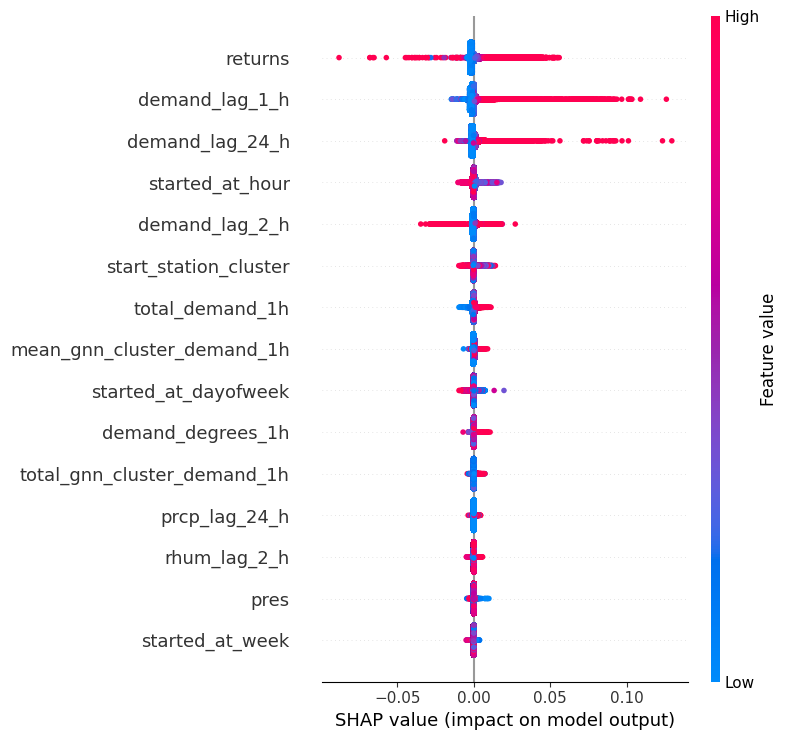

In [7]:
suf = "_o_xgb_02_25_holdout"
model_o, X_o, explainer_o, shap_values_o = get_explainability(suf)



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


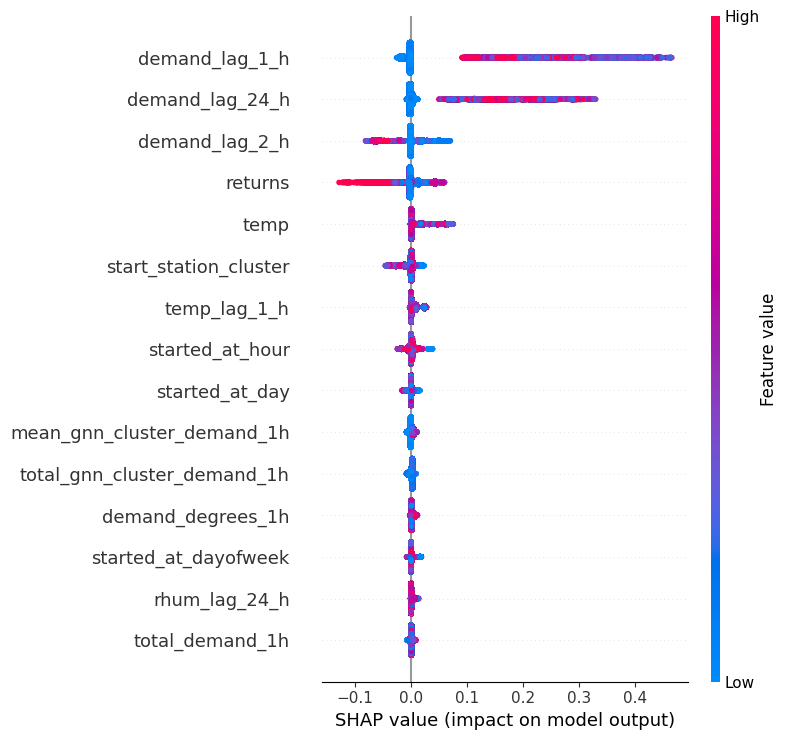

In [8]:
model_o_u, X_o_u, explainer_o_u, shap_values_o_u = get_explainability_unscaled(suf)

In [9]:
y_pred = X_o["pred"]
bins = [-np.inf, 2, 5, np.inf]
labels = ["Demand < 2", "2 ≤ Demand < 5", "Demand ≥ 5"]
y_classes = pd.cut(y_pred, bins=bins, labels=labels)

In [10]:
import matplotlib.pyplot as plt

<ipython-input-11-21fe9bd41300>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_shap_values = shap_df.groupby('Class').apply(lambda x: x.iloc[:, :-1].abs().mean()).T
<ipython-input-11-21fe9bd41300>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_shap_values = shap_df.groupby('Class').apply(lambda x: x.iloc[:, :-1].abs().mean()).T


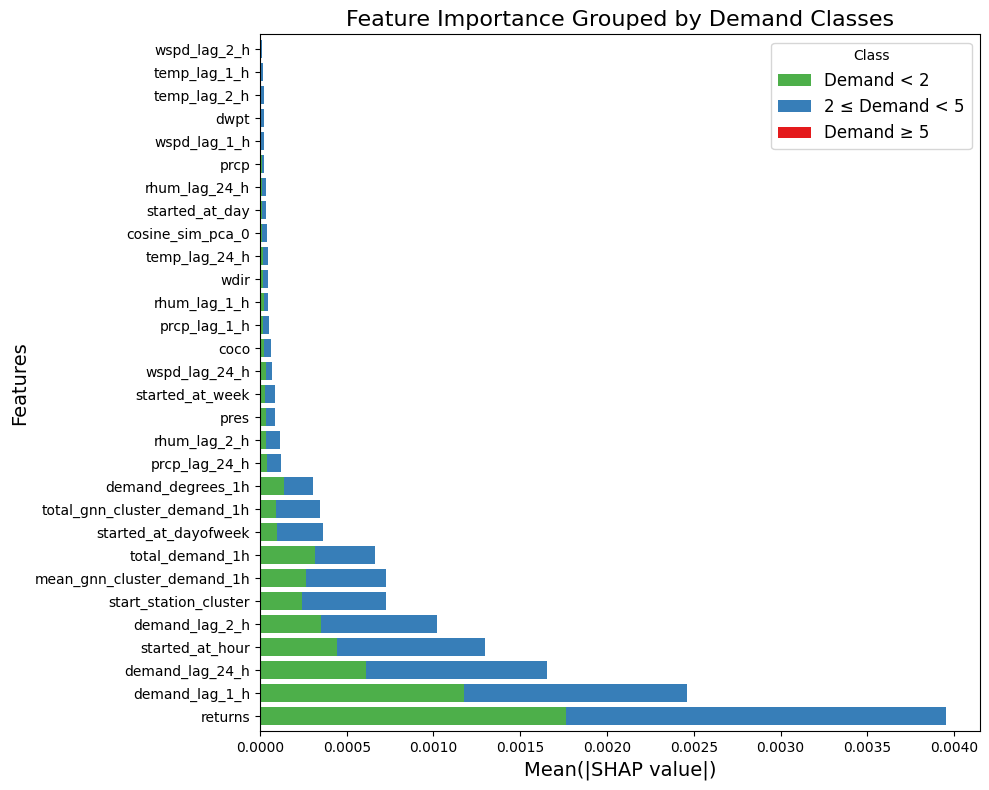

In [11]:
# Prepare DataFrame with SHAP values and class labels
shap_df = pd.DataFrame(shap_values_o, columns=X_o.drop(columns=removed_cols).columns)
shap_df['Class'] = y_classes
shap_df = shap_df[shap_df['Class'] != 'Demand ≥ 5']
# Calculate mean absolute SHAP values for each feature per class
mean_shap_values = shap_df.groupby('Class').apply(lambda x: x.iloc[:, :-1].abs().mean()).T
mean_shap_values.columns = labels

# Sort features by total mean SHAP value across all classes (optional)
mean_shap_values['Total'] = mean_shap_values.sum(axis=1)
mean_shap_values = mean_shap_values.sort_values(by='Total', ascending=False).drop('Total', axis=1)

# Plot horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 8))
mean_shap_values[0:30].plot(kind='barh', stacked=True, ax=ax, width=0.8, color=['#4daf4a', '#377eb8', '#e41a1c'])

# Customize the plot
plt.title('Feature Importance Grouped by Demand Classes', fontsize=16)
plt.xlabel('Mean(|SHAP value|)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.legend(title="Class", fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
mean_shap_values.sort_values("Demand ≥ 5", ascending=False)

,Demand < 2,2 ≤ Demand < 5,Demand ≥ 5
returns,0.001764,0.002187,NaN
demand_lag_1_h,0.001178,0.001280,NaN
demand_lag_24_h,0.000611,0.001043,NaN
started_at_hour,0.000443,0.000853,NaN
demand_lag_2_h,0.000352,0.000669,NaN
start_station_cluster,0.000241,0.000486,NaN
mean_gnn_cluster_demand_1h,0.000268,0.000456,NaN
total_demand_1h,0.000315,0.000348,NaN
started_at_dayofweek,0.000100,0.000262,NaN
total_gnn_cluster_demand_1h,0.000094,0.000250,NaN


In [13]:
#X_o['start_station_cluster'].value_counts()

In [14]:
X_o['start_station_cluster'].value_counts()

,count
start_station_cluster,
25,1680
34,1680
3,1680
27,1680
19,1680
33,1680
72,1680
74,1680
73,1680


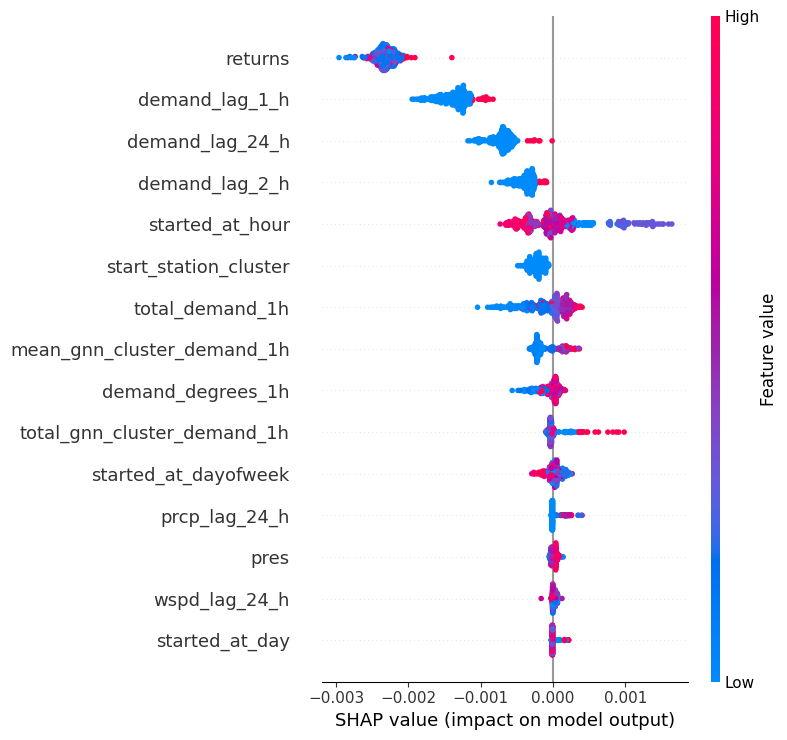

In [15]:
indexes = X_o['start_station_cluster'] == 0

X = X_o.loc[indexes]
shap_values = shap_values_o[X.index]
shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=15)

In [16]:
explainer_o(X.iloc[0:50].drop(columns=removed_cols))

.values =
array([[-1.09183420e-04,  1.00214356e-05, -1.01299729e-05, ...,
        -2.82357709e-04, -2.30008946e-03,  1.73970955e-06],
       [-7.97247631e-05,  9.76249885e-06, -1.01363703e-05, ...,
        -2.37564484e-04, -2.22998462e-03,  1.49868765e-06],
       [-1.57166054e-04,  1.01226933e-05, -1.00528514e-05, ...,
        -2.19533453e-04, -2.40666466e-03,  3.86685588e-06],
       ...,
       [-2.16914399e-04,  2.22081007e-06, -1.24671615e-05, ...,
        -1.63634843e-06, -2.25957716e-03,  7.62183799e-06],
       [-2.07852674e-04,  5.46808587e-06, -1.30454346e-05, ...,
         1.47383230e-06, -2.40990217e-03,  9.12128598e-06],
       [-2.18038564e-04,  2.17260526e-06, -1.12493190e-05, ...,
         1.08099402e-05, -2.34563067e-03,  8.95386802e-06]], dtype=float32)

.base_values =
array([1.0051429, 1.0051429, 1.0051429, 1.0051429, 1.0051429, 1.0051429,
       1.0051429, 1.0051429, 1.0051429, 1.0051429, 1.0051429, 1.0051429,
       1.0051429, 1.0051429, 1.0051429, 1.0051429, 1.005

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[[1.03198957]]
11.356298923492432
9.0


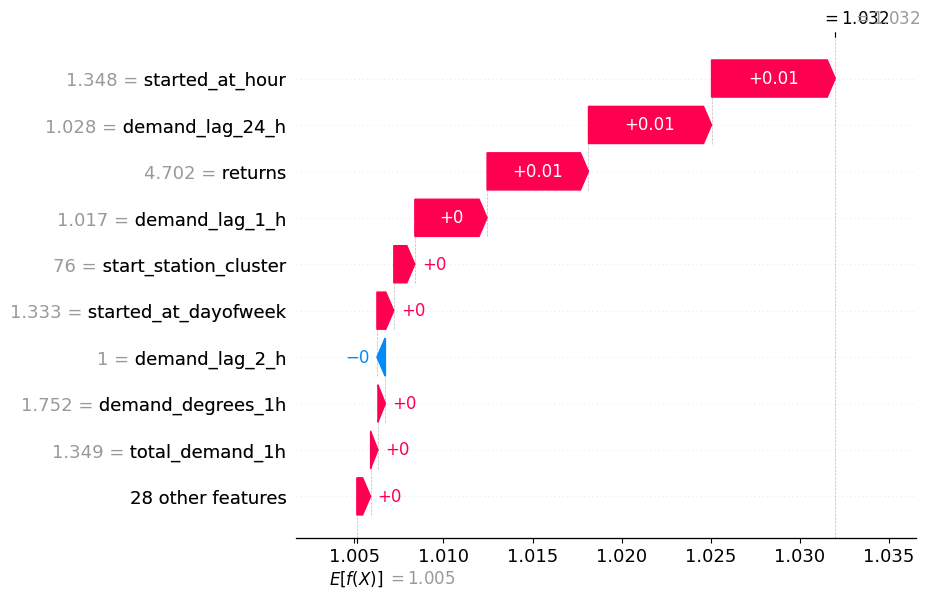

In [17]:
index = 3
indexes = X_o['start_station_cluster'] == label_encoder.transform([158])[0]
X = X_o.loc[indexes]
X = X[X['actual_demand'] == 9]
print(target_scaler.transform([[X.iloc[index]['pred']]]))
print(X.iloc[index]['pred'])
print(X.iloc[index]['actual_demand'])

explained = explainer_o(X.iloc[0:50].drop(columns=removed_cols))
shap.plots.waterfall(explained[index])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[[1.0125345]]
4.449747204780579


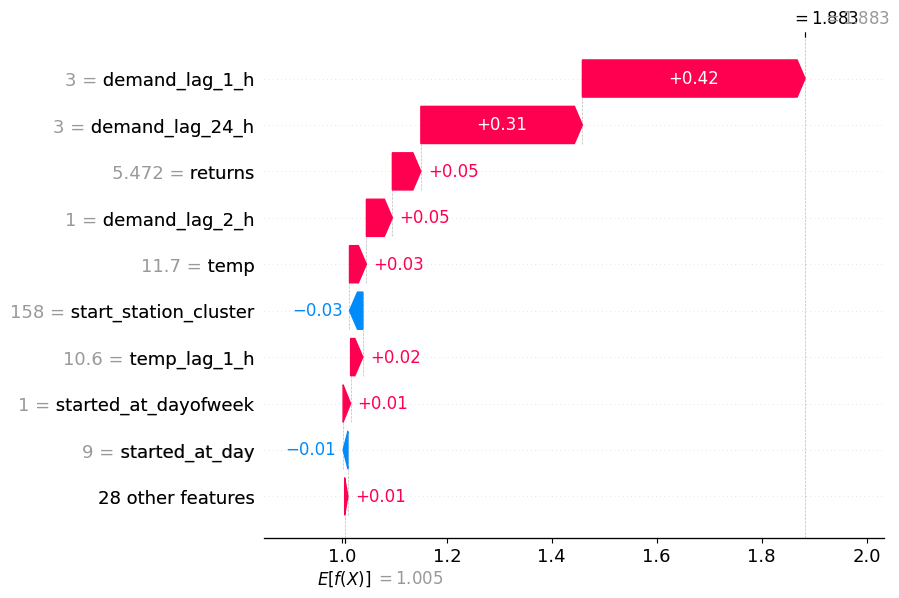

In [18]:
indexes = X_o_u['start_station_cluster'] == 158

X = X_o_u.loc[indexes]
X = X[X['actual_demand'] == 7.0]
print(target_scaler.transform([[X.iloc[index]['pred']]]))
print(X.iloc[index]['pred'])

explained = explainer_o_u(X.iloc[0:50].drop(columns=removed_cols))
shap.plots.waterfall(explained[index])

# Feature Importance

<Axes: >

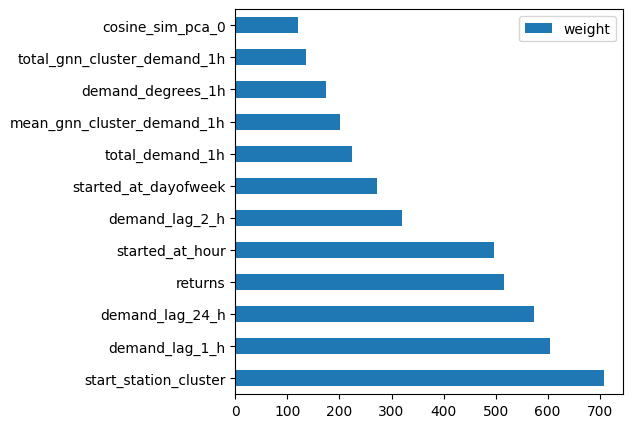

In [19]:
feature_important = model_o.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_weight = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=True)
data_weight = data_weight.rename(columns={"score": "weight"})
data_weight.loc[[i for i in data_weight.index  if "dim_var" not in i]].nlargest(12, columns="weight").plot(kind='barh', figsize = (5, 5)) ## plot top 40 features


<Axes: >

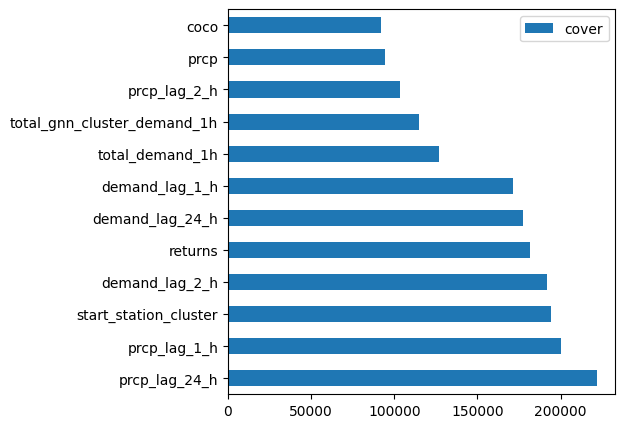

In [20]:
feature_important = model_o.get_booster().get_score(importance_type='cover')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_cover = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=True)
data_cover = data_cover.rename(columns={"score": "cover"})
data_cover.loc[[i for i in data_cover.index  if "dim_var" not in i]].nlargest(12, columns="cover").plot(kind='barh', figsize = (5, 5)) ## plot top 40 features

<Axes: >

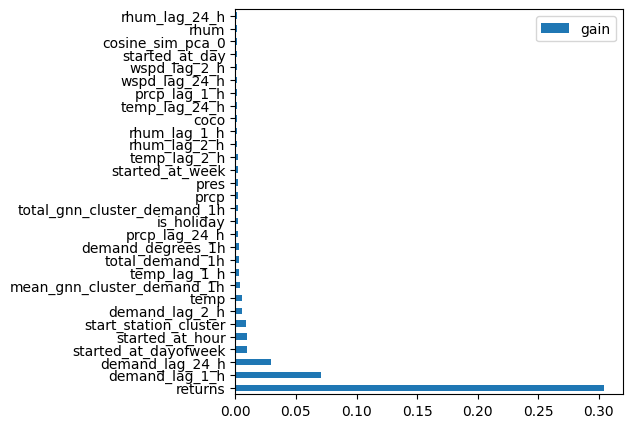

In [21]:
feature_important = model_o.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_gain = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=True)
data_gain = data_gain.rename(columns={"score": "gain"})
data_gain.loc[[i for i in data_gain.index  if "dim_var" not in i]].nlargest(30, columns="gain").plot(kind='barh', figsize = (5, 5)) ## plot top 40 features

In [22]:
feature_importance = pd.concat([data_gain.sort_index().rename(columns={"score": "gain"}), data_cover.sort_index().rename(columns={"score": "cover"}), data_weight.sort_index().rename(columns={"score": "weight"})], axis=1)

In [23]:
feature_importance['gain_rank'] = feature_importance['gain'].rank(method='max', ascending=False)
feature_importance['cover_rank'] = feature_importance['cover'].rank(method='max', ascending=False)

In [24]:
feature_importance.shape

(36, 5)

In [25]:
36/3

12.0

# Gain

2 out of the highest 12 features are out of the top 12 features in regards to weight vs gain. 1 feature is in the next top 12, another is in the lowest.

7 out of the next highest 12 features are out of the top 12 features in regards to weight vs gain. 1 feature is in the top 12, 6 in the lowest.

6 out of the lowest 12 features are out of the top 12 features in regards to weight vs gain. All of them are at the middle


# Cover
5 out of the highest 12 features are out of the top 12 features in regards to weight vs cover.

7 out of the next highest 12 features are out of the top 12 features in regards to weight vs cover.

6 out of the lowest 12 features are out of the top 12 features in regards to weight vs cover.

In [26]:
feature_importance.sort_values("gain_rank").reset_index()

,index,gain,cover,weight,gain_rank,cover_rank
0,returns,0.304609,181896.234375,517.0,1.0,5.0
1,demand_lag_1_h,0.070609,171275.296875,604.0,2.0,7.0
2,demand_lag_24_h,0.029778,177400.281250,574.0,3.0,6.0
3,started_at_dayofweek,0.009996,32188.478516,272.0,4.0,24.0
4,started_at_hour,0.009791,86865.421875,497.0,5.0,14.0
5,start_station_cluster,0.008891,194205.406250,709.0,6.0,3.0
6,demand_lag_2_h,0.005465,191906.343750,321.0,7.0,4.0
7,temp,0.005262,15755.666992,87.0,8.0,30.0
8,mean_gnn_cluster_demand_1h,0.004135,83523.296875,201.0,9.0,15.0
9,temp_lag_1_h,0.003156,67532.281250,53.0,10.0,16.0


# RMSE By Cluster

In [27]:
def get_combined_df(suf):
  model_preds_best = pd.read_csv(f"{models_dir}/test_predictions{suf}_best.csv")
  model_preds_worst = pd.read_csv(f"{models_dir}/test_predictions{suf}_worst.csv")

  df = pd.concat([model_preds_best, model_preds_worst])
  return df

  # filename = f'{models_dir}/demand_model{suf}.sav'
  # model = joblib.load(filename)
  # X = model_preds.drop(columns=['Unnamed: 0', 'actual_demand', 'pred'])
  # explainer = shap.TreeExplainer(model)
  # shap_values = explainer.shap_values(X)

  # shap.summary_plot(shap_values, X)
  # #shap.force_plot(explainer.expected_value, shap_values, X)

  # return model, model_preds, explainer, shap_values

In [28]:
X_o_combined = get_combined_df("_o_xgb_02_25_holdout")

In [29]:


label_encoder = joblib.load(f'{models_dir}/start_station_encoder.sav')
datetime_scaler = joblib.load(f'{models_dir}/datetime_features_scaler.sav')
def get_all_results(X):
  all_results_df = pd.DataFrame()

  data = X.copy()
  data['start_station_cluster_original'] = label_encoder.inverse_transform(data['start_station_cluster'])

  for cluster in data['start_station_cluster_original'].unique():
    indexes = data['start_station_cluster_original'] == cluster
    X = data.loc[indexes]
    X_non_zero = data.loc[indexes & (data['actual_demand'] != 0)]
    X_zero = data.loc[indexes & (data['actual_demand'] == 0)]

    X_under_predicting = data.loc[indexes & (data['actual_demand'] > data['pred'])]
    X_over_predicting = data.loc[indexes & (data['actual_demand'] < data['pred'])]

    results = pd.DataFrame(data={
        "cluster_original": [cluster],
        "cluster": [X.iloc[0]['start_station_cluster']],
        "MAPE": [mean_absolute_percentage_error(X['actual_demand']+1, X['pred']+1)],
        "MSE": [mean_squared_error(X['actual_demand'], X['pred'])],
        "RMSE": [np.sqrt(mean_squared_error(X['actual_demand'], X['pred']))],

        "under_predicting_MAPE": [mean_absolute_percentage_error(X_under_predicting['actual_demand']+1, X_under_predicting['pred']+1)],
        "under_predicting_MSE": [mean_squared_error(X_under_predicting['actual_demand'], X_under_predicting['pred'])],
        "under_predicting_RMSE": [np.sqrt(mean_squared_error(X_under_predicting['actual_demand'], X_under_predicting['pred']))],

        "over_predicting_MAPE": [mean_absolute_percentage_error(X_over_predicting['actual_demand']+1, X_over_predicting['pred']+1)],
        "over_predicting_MSE": [mean_squared_error(X_over_predicting['actual_demand'], X_over_predicting['pred'])],
        "over_predicting_RMSE": [np.sqrt(mean_squared_error(X_over_predicting['actual_demand'], X_over_predicting['pred']))],

        "non_zero_MAPE": [mean_absolute_percentage_error(X_non_zero['actual_demand']+1, X_non_zero['pred']+1)],
        "non_zero_MSE": [mean_squared_error(X_non_zero['actual_demand'], X_non_zero['pred'])],
        "non_zero_RMSE": [np.sqrt(mean_squared_error(X_non_zero['actual_demand'], X_non_zero['pred']))],

        "zero_MAPE": [mean_absolute_percentage_error(X_zero['actual_demand']+1, X_zero['pred']+1)],
        "zero_MSE": [mean_squared_error(X_zero['actual_demand'], X_zero['pred'])],
        "zero_RMSE": [np.sqrt(mean_squared_error(X_zero['actual_demand'], X_zero['pred']))],

        "max_demand": [X['actual_demand'].max()],
        "min_demand": [X['actual_demand'].min()],
        "mean_demand": [X['actual_demand'].mean()],
        "median_demand": [X['actual_demand'].median()]
    })
    all_results_df = pd.concat([all_results_df, results])
  return all_results_df, data

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [30]:
combined_all_results_df, data_combined = get_all_results(X_o_combined)
all_results_df, data = get_all_results(X_o)

In [31]:
SCALER_DATETIME_FEATURES = [
    'started_at_year',
    'started_at_month',
    'started_at_day',
    'started_at_hour',
    'started_at_week',
    'started_at_quarter',
    'started_at_dayofweek',
]


In [32]:
data_combined['started_at_year'] = 2024
data_combined['started_at_quarter'] = 1
data_combined[SCALER_DATETIME_FEATURES] = pd.DataFrame(datetime_scaler.inverse_transform(data_combined[SCALER_DATETIME_FEATURES]), columns=SCALER_DATETIME_FEATURES)
data_combined['started_at_year'] = 2024

In [33]:
data['started_at_year'] = 2024
data['started_at_quarter'] = 1
data[SCALER_DATETIME_FEATURES] = pd.DataFrame(datetime_scaler.inverse_transform(data[SCALER_DATETIME_FEATURES]), columns=SCALER_DATETIME_FEATURES)
data['started_at_year'] = 2024

In [34]:
def get_rmses(X):


  print("Overall MSE: ", (mean_squared_error(X['actual_demand'], X['pred'])))

  under_predicting = X[(X['actual_demand'] > X['pred'])]
  print("under-predicting MSE:", (mean_squared_error(under_predicting['actual_demand'], under_predicting['pred'])))

  over_predicting = X[(X['actual_demand'] < X['pred'])]
  print("over-predicting MSE:", (mean_squared_error(over_predicting['actual_demand'], over_predicting['pred'])))

  non_zeros = X[(X['actual_demand'] != 0)]
  print("Non-Zero MSE:", (mean_squared_error(non_zeros['actual_demand'], non_zeros['pred'])))

  zeros = X[(X['actual_demand'] == 0)]
  print("Zero MSE:", (mean_squared_error(zeros['actual_demand'], zeros['pred'])))
  print()

  print("Overall RMSE: ", np.sqrt(mean_squared_error(X['actual_demand'], X['pred'])))

  under_predicting = X[(X['actual_demand'] > X['pred'])]
  print("under-predicting RMSE:", np.sqrt(mean_squared_error(under_predicting['actual_demand'], under_predicting['pred'])))

  over_predicting = X[(X['actual_demand'] < X['pred'])]
  print("over-predicting RMSE:", np.sqrt(mean_squared_error(over_predicting['actual_demand'], over_predicting['pred'])))

  non_zeros = X[(X['actual_demand'] != 0)]
  print("Non-Zero RMSE:", np.sqrt(mean_squared_error(non_zeros['actual_demand'], non_zeros['pred'])))

  zeros = X[(X['actual_demand'] == 0)]
  print("Zero RMSE:", np.sqrt(mean_squared_error(zeros['actual_demand'], zeros['pred'])))
  print()

  print("Overall MAE: ", (mean_absolute_error(X['actual_demand'], X['pred'])))

  under_predicting = X[(X['actual_demand'] > X['pred'])]
  print("under-predicting MAE:", (mean_absolute_error(under_predicting['actual_demand'], under_predicting['pred'])))

  over_predicting = X[(X['actual_demand'] < X['pred'])]
  print("over-predicting MAE:", (mean_absolute_error(over_predicting['actual_demand'], over_predicting['pred'])))

  non_zeros = X[(X['actual_demand'] != 0)]
  print("Non-Zero MAE:", (mean_absolute_error(non_zeros['actual_demand'], non_zeros['pred'])))

  zeros = X[(X['actual_demand'] == 0)]
  print("Zero MAE:", (mean_absolute_error(zeros['actual_demand'], zeros['pred'])))
  print()

  print("Overall MAPE: ", (mean_absolute_percentage_error(X['actual_demand']+1, X['pred']+1)))

  under_predicting = X[(X['actual_demand'] > X['pred'])]
  print("under-predicting MAPE:", (mean_absolute_percentage_error(under_predicting['actual_demand']+1, under_predicting['pred']+1)))

  over_predicting = X[(X['actual_demand'] < X['pred'])]
  print("over-predicting MAPE:", (mean_absolute_percentage_error(over_predicting['actual_demand']+1, over_predicting['pred']+1)))

  non_zeros = X[(X['actual_demand'] != 0)]
  print("Non-Zero MAPE:", (mean_absolute_percentage_error(non_zeros['actual_demand']+1, non_zeros['pred']+1)))

  zeros = X[(X['actual_demand'] == 0)]
  print("Zero MAPE:", (mean_absolute_percentage_error(zeros['actual_demand']+1, zeros['pred']+1)))




In [35]:
get_rmses(X_o)

Overall MSE:  3.4385015032398725
under-predicting MSE: 6.882109914583898
over-predicting MSE: 1.7440471234765553
Non-Zero MSE: 7.0195122167807344
Zero MSE: 0.5290595469456003

Overall RMSE:  1.8543196874433148
under-predicting RMSE: 2.623377577586554
over-predicting RMSE: 1.3206237630288784
Non-Zero RMSE: 2.6494362073431272
Zero RMSE: 0.7273647963337243

Overall MAE:  0.9873230419200121
under-predicting MAE: 1.540096327632289
over-predicting MAE: 0.715364044016261
Non-Zero MAE: 1.6766834387513974
Zero MAE: 0.4272426003941237

Overall MAPE:  0.3942077604799864
under-predicting MAPE: 0.27598831515783506
over-predicting MAPE: 0.45242257589500096
Non-Zero MAPE: 0.35354768977580636
Zero MAPE: 0.4272426003941237


In [36]:
get_rmses(X_o_combined)

Overall MSE:  3.2563628109316602
under-predicting MSE: 6.684587694209287
over-predicting MSE: 1.6166718488330587
Non-Zero MSE: 6.659491668922101
Zero MSE: 0.4914434420300776

Overall RMSE:  1.8045395010726866
under-predicting RMSE: 2.5854569604248465
over-predicting RMSE: 1.2714841126939254
Non-Zero RMSE: 2.580599091087591
Zero RMSE: 0.7010302718357301

Overall MAE:  0.9613060229051136
under-predicting MAE: 1.5426146872339865
over-predicting MAE: 0.6833360299151714
Non-Zero MAE: 1.6347794163830718
Zero MAE: 0.41413319819854066

Overall MAPE:  0.3832489796453322
under-predicting MAPE: 0.2786716097181206
over-predicting MAPE: 0.4333441472996322
Non-Zero MAPE: 0.3452359451253919
Zero MAPE: 0.41413319819854066


Overall RMSE:  1.818450601595066

under-predicting RMSE: 2.5948662711392454

over-predicting RMSE: 1.2863553185454326

Non-Zero RMSE: 2.5943250959516986

Zero RMSE: 0.7123119007062843

Overall RMSE:  1.864978282804273

under-predicting RMSE: 2.6404490567232237

over-predicting RMSE: 1.327030316159137

Non-Zero RMSE: 2.661143531908538

Zero RMSE: 0.7292291824249435

# Visualizations

In [37]:
import plotly.express as px
import plotly.graph_objects as go

In [38]:
all_results_df

,cluster_original,cluster,MAPE,MSE,RMSE,under_predicting_MAPE,under_predicting_MSE,under_predicting_RMSE,over_predicting_MAPE,over_predicting_MSE,over_predicting_RMSE,non_zero_MAPE,non_zero_MSE,non_zero_RMSE,zero_MAPE,zero_MSE,zero_RMSE,max_demand,min_demand,mean_demand,median_demand
0,74,0.0,0.094560,0.045654,0.213667,0.141064,0.213827,0.462414,0.085889,0.014299,0.119580,0.436890,0.779590,0.882944,0.079231,0.012791,0.113097,1.0,0.0,0.042857,0.0
0,75,1.0,0.100253,0.059276,0.243467,0.135269,0.272289,0.521813,0.093675,0.019263,0.138789,0.472861,1.086471,1.042339,0.084915,0.016994,0.130362,2.0,0.0,0.043023,0.0
0,76,2.0,0.100974,0.048789,0.220882,0.124727,0.186926,0.432350,0.096109,0.020496,0.143163,0.422584,0.734604,0.857091,0.086496,0.017916,0.133851,1.0,0.0,0.043077,0.0
0,77,3.0,0.468184,2.479879,1.574763,0.306819,3.888073,1.971820,0.598004,1.346972,1.160591,0.348912,3.256273,1.804515,0.687960,1.049265,1.024336,12.0,0.0,1.732143,1.0
0,78,4.0,0.189261,0.221475,0.470611,0.241853,0.643079,0.801922,0.171122,0.074997,0.273855,0.427892,1.197599,1.094349,0.150925,0.064659,0.254282,5.0,0.0,0.163415,0.0
0,79,5.0,0.099211,0.054348,0.233127,0.113884,0.210558,0.458866,0.096064,0.019617,0.140059,0.471045,1.059542,1.029341,0.085325,0.016810,0.129653,2.0,0.0,0.039000,0.0
0,80,6.0,0.116716,0.089810,0.299683,0.159376,0.335654,0.579356,0.105201,0.022993,0.151634,0.459201,1.090635,1.044335,0.092661,0.019518,0.139705,4.0,0.0,0.071250,0.0
0,81,7.0,0.138155,0.112252,0.335040,0.176365,0.371616,0.609603,0.127100,0.037215,0.192913,0.453922,1.067775,1.033332,0.111196,0.030675,0.175142,3.0,0.0,0.087195,0.0
0,82,8.0,0.125590,0.114219,0.337963,0.169308,0.422636,0.650105,0.113939,0.032028,0.178965,0.460045,1.290411,1.135963,0.100898,0.027386,0.165487,3.0,0.0,0.081944,0.0
0,83,9.0,0.124880,0.089790,0.299650,0.150101,0.289440,0.537996,0.118202,0.036119,0.190050,0.434632,0.944297,0.971749,0.103422,0.030593,0.174907,2.0,0.0,0.070423,0.0


In [39]:
def add_datetime(df, column_name="started_at"):
    conversion_dict_hourly = dict(year= df[f'{column_name}_year'].astype(str),
                                  month=df[f'{column_name}_month'].astype(str),
                                  day=  df[f'{column_name}_day'].astype(str),
                                  hour= df[f'{column_name}_hour'].astype(str)
                                 )
    conversion_dict_daily = dict(year= df[f'{column_name}_year'].astype(str),
                           month=df[f'{column_name}_month'].astype(str),
                           day=  df[f'{column_name}_day'].astype(str)
                                 )
    df[f'{column_name}_hourly'] = pd.to_datetime(conversion_dict_hourly)

    df[f'{column_name}_daily'] = pd.to_datetime(conversion_dict_daily)

    return df

In [40]:
data = add_datetime(data)

In [41]:
data_combined = add_datetime(data_combined)

In [42]:
def pred_vs_demand(demand_hourly_overall, title,
                   time_col='started_at_hourly', start_date="2024-1-1", end_date="2024-1-10"):
    one_month = demand_hourly_overall[(demand_hourly_overall[time_col] > pd.to_datetime(start_date)) &
                                        (demand_hourly_overall[time_col] < pd.to_datetime(end_date))]

    sorted_df = one_month.sort_values(time_col)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sorted_df[time_col],
                             y=sorted_df['Demand'],
                             mode='lines',
                             name='Demand'))

    sorted_df = one_month.sort_values(time_col)

    fig.add_trace(go.Scatter(x=sorted_df[time_col],
                             y=sorted_df['Prediction'],
                             mode='lines',
                             name='Prediction'))

    fig.update_layout(hovermode="x")

    fig.update_layout(title=f'{title}',
                       xaxis_title='Time'
                     )

    #fig.write_html(f"Plots/{title}.html")
    return fig

In [43]:
thresholds = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

for threshold in thresholds:
  filtering_cluster = all_results_df[all_results_df["non_zero_RMSE"] > threshold]['cluster']

  X = X_o.loc[X_o['start_station_cluster'].isin(filtering_cluster)]

  print(f"RMSE {threshold}: ", np.sqrt(mean_squared_error(X['actual_demand'], X ['pred'])))

RMSE 1.5:  2.6618240799030284
RMSE 2.0:  3.2201401643815064
RMSE 2.5:  3.5336164278254176
RMSE 3.0:  4.029225722783924
RMSE 3.5:  4.6839168863923115
RMSE 4.0:  5.00251960112254
RMSE 4.5:  5.752672881924372
RMSE 5.0:  5.752672881924372


## Exclude With SHAP

In [106]:
df['slope_change'].quantile(0.95)

np.float64(0.03583993907272634)

In [105]:
df = all_results_df.sort_values(['non_zero_RMSE']).reset_index()

# Create plot
fig = go.Figure()

df['y'] = df['non_zero_RMSE']
df['x'] = df.index
# Original curve
fig.add_trace(go.Scatter(x=df['x'], y=df['y'], mode='lines+markers', name='Original Curve'))

from scipy.signal import savgol_filter

# Compute the slope (dy/dx)
df['slope'] = np.gradient(df['y'], df['x'])

# Mark points where slope changes significantly
df['slope_change'] = np.abs(np.gradient(df['slope']))  # Change in slope
threshold = df['slope_change'].quantile(0.95)  # Top 5% of slope changes
df['is_critical'] = df['slope_change'] > threshold  # Mark critical points

# Create the figure
fig = go.Figure()

# Add original curve
fig.add_trace(go.Scatter(
    x=df['x'], y=df['y'], mode='lines+markers',
    marker=dict(size=8, colorscale='RdYlBu'),
    name='Curve'
))

# Display DataFrame
#print(df)

# Customize layout
fig.update_layout(
    title="Curve with Slopes and Candidate Thresholds",
    xaxis_title="Station Indexes",
    yaxis_title="RMSEs",
)

fig.show()

In [74]:
all_results_df

,cluster_original,cluster,MAPE,MSE,RMSE,under_predicting_MAPE,under_predicting_MSE,under_predicting_RMSE,over_predicting_MAPE,over_predicting_MSE,over_predicting_RMSE,non_zero_MAPE,non_zero_MSE,non_zero_RMSE,zero_MAPE,zero_MSE,zero_RMSE,max_demand,min_demand,mean_demand,median_demand
0,74,0.0,0.094560,0.045654,0.213667,0.141064,0.213827,0.462414,0.085889,0.014299,0.119580,0.436890,0.779590,0.882944,0.079231,0.012791,0.113097,1.0,0.0,0.042857,0.0
0,75,1.0,0.100253,0.059276,0.243467,0.135269,0.272289,0.521813,0.093675,0.019263,0.138789,0.472861,1.086471,1.042339,0.084915,0.016994,0.130362,2.0,0.0,0.043023,0.0
0,76,2.0,0.100974,0.048789,0.220882,0.124727,0.186926,0.432350,0.096109,0.020496,0.143163,0.422584,0.734604,0.857091,0.086496,0.017916,0.133851,1.0,0.0,0.043077,0.0
0,77,3.0,0.468184,2.479879,1.574763,0.306819,3.888073,1.971820,0.598004,1.346972,1.160591,0.348912,3.256273,1.804515,0.687960,1.049265,1.024336,12.0,0.0,1.732143,1.0
0,78,4.0,0.189261,0.221475,0.470611,0.241853,0.643079,0.801922,0.171122,0.074997,0.273855,0.427892,1.197599,1.094349,0.150925,0.064659,0.254282,5.0,0.0,0.163415,0.0
0,79,5.0,0.099211,0.054348,0.233127,0.113884,0.210558,0.458866,0.096064,0.019617,0.140059,0.471045,1.059542,1.029341,0.085325,0.016810,0.129653,2.0,0.0,0.039000,0.0
0,80,6.0,0.116716,0.089810,0.299683,0.159376,0.335654,0.579356,0.105201,0.022993,0.151634,0.459201,1.090635,1.044335,0.092661,0.019518,0.139705,4.0,0.0,0.071250,0.0
0,81,7.0,0.138155,0.112252,0.335040,0.176365,0.371616,0.609603,0.127100,0.037215,0.192913,0.453922,1.067775,1.033332,0.111196,0.030675,0.175142,3.0,0.0,0.087195,0.0
0,82,8.0,0.125590,0.114219,0.337963,0.169308,0.422636,0.650105,0.113939,0.032028,0.178965,0.460045,1.290411,1.135963,0.100898,0.027386,0.165487,3.0,0.0,0.081944,0.0
0,83,9.0,0.124880,0.089790,0.299650,0.150101,0.289440,0.537996,0.118202,0.036119,0.190050,0.434632,0.944297,0.971749,0.103422,0.030593,0.174907,2.0,0.0,0.070423,0.0


In [45]:
df = all_results_df.sort_values(['non_zero_RMSE']).reset_index()

# Create plot
fig = go.Figure()

df['y'] = df['non_zero_RMSE']
df['x'] = df.index
# Original curve
fig.add_trace(go.Scatter(x=df['x'], y=df['y'], mode='lines+markers', name='Original Curve'))

from scipy.signal import savgol_filter

# Compute the slope (dy/dx)
df['slope'] = np.gradient(df['y'], df['x'])

# Mark points where slope changes significantly
df['slope_change'] = np.abs(np.gradient(df['slope']))  # Change in slope
threshold = df['slope_change'].quantile(0.95)  # Top 5% of slope changes
df['is_critical'] = df['slope_change'] > threshold  # Mark critical points

# Create the figure
fig = go.Figure()

# Add original curve
fig.add_trace(go.Scatter(
    x=df['x'], y=df['y'], mode='lines+markers',
    marker=dict(size=8, colorscale='RdYlBu'),
    name='Curve'
))

# Highlight Critical Slope Points
critical_points = df[df['is_critical']]
fig.add_trace(go.Scatter(
    x=critical_points['x'], y=critical_points['y'],
    mode='markers',
    marker=dict(size=12, color='orangered', symbol='x'),
    name='Candidate Thresholds'
))

# Display DataFrame
#print(df)

# Customize layout
fig.update_layout(
    title="Curve with Slopes and Candidate Thresholds",
    xaxis_title="Station Indexes",
    yaxis_title="RMSEs",
)
fig.update_layout(showlegend=False)
fig.show()

In [49]:
df[df['is_critical'] == True].drop(columns=['index'])[['non_zero_RMSE' ]]

,non_zero_RMSE
130,2.300712
148,3.212676
151,3.462348
153,3.853929
157,4.336652
158,4.391699
159,5.248559
161,5.669358
162,6.872248


RMSE 0 - 2.3:  1.058117037703976
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 58, 61, 63, 64, 66, 67, 68, 70, 73, 74, 75, 76, 78, 80, 82, 83, 84, 85, 87, 90, 92, 93, 96, 98, 100, 101, 103, 104, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 164]


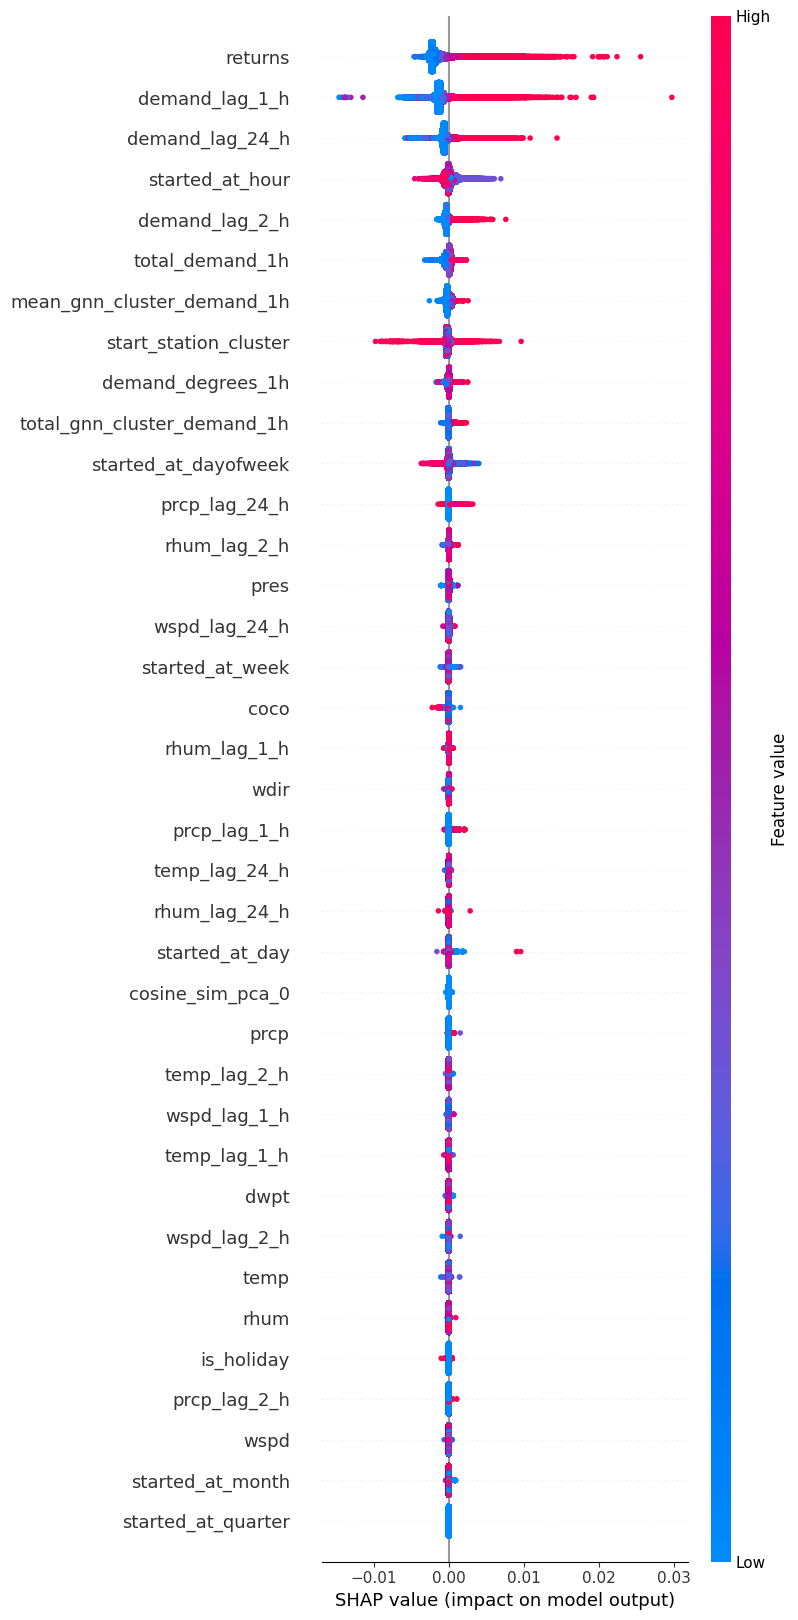

RMSE 2.3 - 3.85:  2.6995424256915883
[34, 39, 42, 53, 57, 59, 60, 62, 72, 77, 81, 88, 89, 95, 97, 99, 102, 106, 113, 118, 145, 154, 163]


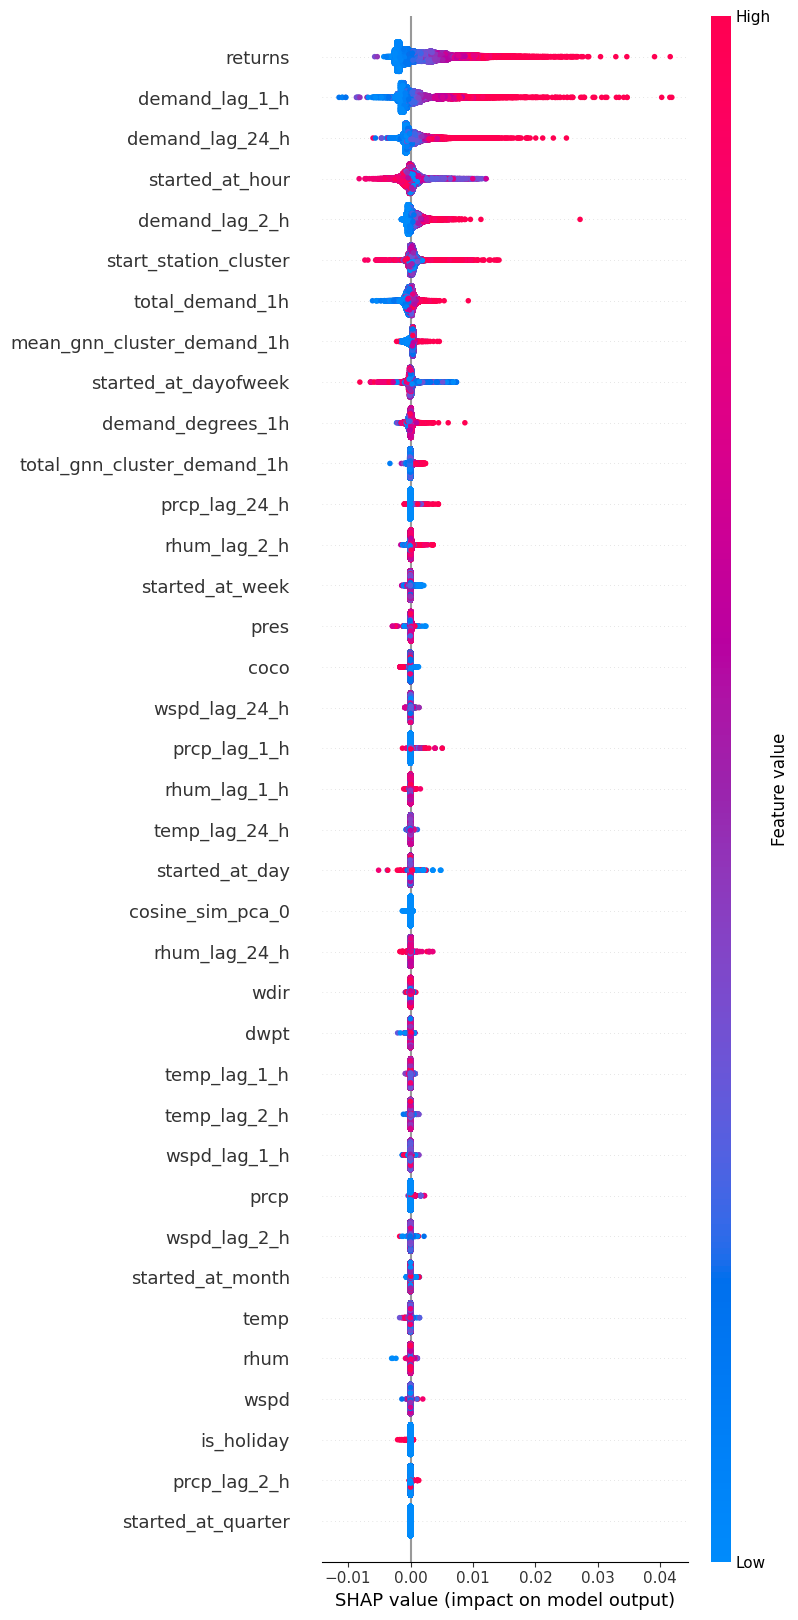

RMSE 3.85 - 2000000000000:  4.7843491185760625
[35, 65, 69, 71, 79, 86, 91, 94, 105, 122]


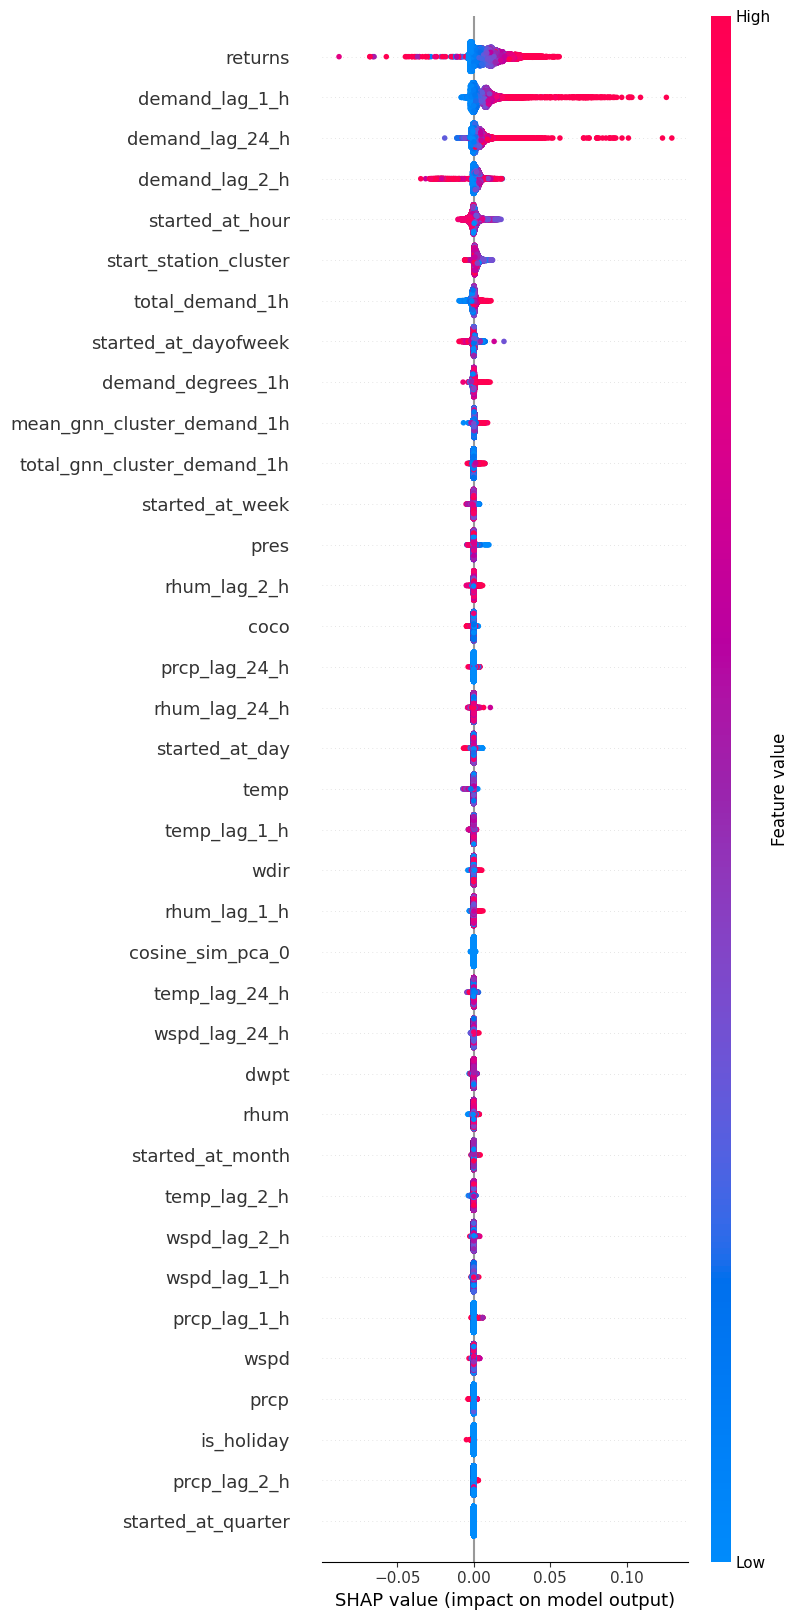

In [47]:
thresholds = [0, 2.30, 3.85, 2000000000000]

for index in range(len(thresholds)-1):

  t1 = thresholds[index]
  t2 = thresholds[index+1]
  filtering_cluster = all_results_df[(all_results_df["non_zero_RMSE"] >= t1) & (all_results_df["non_zero_RMSE"] < t2)]['cluster']

  indexes = X_o['start_station_cluster'].isin(filtering_cluster)
  X = X_o.loc[indexes]
  print(f"RMSE {t1} - {t2}: ", np.sqrt(mean_squared_error(X['actual_demand'], X ['pred'])))
  print([int(i) for i in filtering_cluster.unique()])
  shap_values = shap_values_o[X.index]
  shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

In [48]:


exclude_features = {

    "3.85 - inf": {
        "clusters": [35, 65, 69, 71, 79, 86, 91, 94, 105, 122],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp", "wspd",
            "wspd_lag_1_h", "wspd_lag_2_h", "temp_lag_2_h", "started_at_month",
            "rhum", "dwpt", "wspd_lag_1_h", "temp", "temp_lag_24_h",
            "cosine_sim_pca_0"
        ]
    },

    "2.3 - 3.85": {
        "clusters": [34, 39, 42, 53, 57, 59, 60, 62, 72, 77, 81, 88, 89, 95, 97,
                     99, 102, 106, 113, 118, 145, 154, 163],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd",
            "rhum", "temp", "started_at_month", "wspd_lag_2_h",
            "prcp", "wspd_lag_1_h", "temp_lag_2_h", "temp_lag_1_h", "dwpt",
            "wdir"
        ]
    },

    "0 - 2.3": {
        "clusters": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                     32, 33, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51,
                     52, 54, 55, 56, 58, 61, 63, 66, 67, 68, 70, 73, 74, 75, 76,
                     78, 80, 82, 83, 85, 87, 90, 93, 96, 100, 101, 103, 104,
                     107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 120, 121,
                     124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136,
                     137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150,
                     151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 164],
        "features": [
            "started_at_quarter", "started_at_month", "wspd", "prcp_lag_2_h",
            "is_holiday", "rhum", "temp", "wspd_lag_2_h",  "dwpt",
            "temp_lag_1_h", "wspd_lag_1_h", "temp_lag_2_h", "prcp",
            "cosine_sim_pca_0"
        ]
    },


}


exclude_features = {

    "4.39 - inf": {
        "clusters": [35, 65, 69, 79, 94],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp",
            "prcp_lag_1_h", "wspd", "wspd_lag_1_h", "temp_lag_2_h",
            "wspd_lag_24_h", "wspd_lag_2_h", "started_at_month",
            "dwpt", "cosine_sim_pca_0", "rhum", "temp_lag_24_h"
        ]
    },

    "3.85 - 4.39": {
        "clusters": [71, 86, 91, 105, 122],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday",  "wspd",
            "rhum", "wspd_lag_2_h", "prcp", "temp_lag_2_h", "dwpt", "temp",
            "started_at_month", "wspd_lag_1_h", "temp_lag_24_h"
        ]
    },

    "3.21 - 3.85": {
        "clusters": [53, 62, 99, 145, 154],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday",  "wspd",
            "rhum", "wspd_lag_2_h", "temp", "started_at_month", "prcp",
            "temp_lag_2_h", "temp_lag_1_h", "cosine_sim_pca_0"
        ]
    },

    "2.84 - 3.21": {
        "clusters": [34, 42, 57, 59, 60, 72, 81, 88, 89, 102],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday",  "wspd",
            "temp", "rhum", "started_at_month", "wspd_lag_2_h", "temp_lag_2_h",
            "prcp", "wspd_lag_1_h", "temp_lag_1_h", "dwpt", "wdir"
        ]
    },

    "2.38 - 2.84": {
        "clusters": [39, 77, 95, 97, 113, 118, 163],
        "features": [
            "started_at_quarter", "is_holiday", "prcp_lag_2_h", "wspd",
            "rhum", "temp", "started_at_month", "wspd_lag_2_h", "wspd_lag_1_h",
            "temp_lag_2_h", "prcp", "dwpt", "temp_lag_1_h", "rhum_lag_24_h"
        ]
    },

    "2.06 - 2.38": {
        "clusters": [64, 84, 92, 98, 106, 123, 130, 144, 155],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "wspd", "started_at_month",
            "is_holiday", "rhum", "temp", "wspd_lag_2_h", "temp_lag_1_h",
            "wspd_lag_1_h", "prcp", "dwpt", "temp_lag_2_h", "rhum_lag_24_h"
        ]
    },

    "0 - 2.06": {
        "clusters": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                     32, 33, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51,
                     52, 54, 55, 56, 58, 61, 63, 66, 67, 68, 70, 73, 74, 75, 76,
                     78, 80, 82, 83, 85, 87, 90, 93, 96, 100, 101, 103, 104,
                     107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 120, 121,
                     124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136,
                     137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150,
                     151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 164],
        "features": [
            "started_at_quarter", "started_at_month", "wspd", "prcp_lag_2_h",
            "is_holiday", "rhum", "temp", "wspd_lag_2_h",  "dwpt",
            "temp_lag_1_h", "wspd_lag_1_h", "temp_lag_2_h", "prcp",
            "cosine_sim_pca_0"
        ]
    },


}

In [68]:

exclude_features_slope = {

    "3.85 - inf": {
        "clusters": [35, 65, 69, 71, 79, 86, 91, 94, 105, 122],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp", "wspd",
            "wspd_lag_1_h", "wspd_lag_2_h", "temp_lag_2_h", "started_at_month",
            "rhum", "dwpt", "wspd_lag_1_h", "temp", "temp_lag_24_h",
            "cosine_sim_pca_0"
        ],

        "most_optimal": [ #21.627476640892645
            'started_at_quarter', 'prcp_lag_2_h', 'prcp', 'wspd_lag_2_h', 'temp', 'cosine_sim_pca_0'
        ]
    },

    "2.3 - 3.85": {
        "clusters": [34, 39, 42, 53, 57, 59, 60, 62, 72, 77, 81, 88, 89, 95, 97,
                     99, 102, 106, 113, 118, 145, 154, 163],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd",
            "rhum", "temp", "started_at_month", "wspd_lag_2_h",
            "prcp", "wspd_lag_1_h", "temp_lag_2_h", "temp_lag_1_h", "dwpt",
            "wdir"
        ],

        "most_optimal": [ #6.739131558843824
            'started_at_quarter', 'prcp_lag_2_h', 'wspd', 'rhum',
            'started_at_month', 'wspd_lag_2_h', 'prcp', 'wspd_lag_1_h',
            'temp_lag_2_h', 'temp_lag_1_h'
        ]
    },

    "0 - 2.3": {
        "clusters": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                     32, 33, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51,
                     52, 54, 55, 56, 58, 61, 63, 64, 66, 67, 68, 70, 73, 74, 75,
                     76, 78, 80, 82, 83, 84, 85, 87, 90, 92, 93, 96, 98, 100,
                     101, 103, 104, 107, 108, 109, 110, 111, 112, 114, 115, 116,
                     117, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131,
                     132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
                     144, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157,
                     158, 159, 160, 161, 162, 164],
        "features": [
            "started_at_quarter", "started_at_month", "wspd", "prcp_lag_2_h",
            "is_holiday", "rhum", "temp", "wspd_lag_2_h",  "dwpt",
            "temp_lag_1_h", "wspd_lag_1_h", "temp_lag_2_h", "prcp",
            "cosine_sim_pca_0"
        ],

        "most_optimal": [ #1.0583844883909233
            'started_at_month', 'prcp_lag_2_h', 'is_holiday', 'dwpt',
            'temp_lag_1_h', 'temp_lag_2_h', 'cosine_sim_pca_0'
        ]
    },


}

### Slope Partitions On Map

In [64]:
full_data = pd.read_csv(f"df_final_dataframe.csv").drop(columns=['Unnamed: 0'])

In [65]:
full_data_2024 = full_data[pd.to_datetime(full_data['started_at_hourly'])>=pd.to_datetime("2024-01-01")]
agg = full_data_2024.groupby(['start_station_cluster', 'start_station_id'])['ride_id'].count()
agg = agg.reset_index().rename(
    columns = {'ride_id': "actual_demand"}
)

In [66]:
standard_stations = pd.read_csv(f"{data_dir}/standard_stations.csv").drop(columns=['Unnamed: 0'])
standard_stations = standard_stations.merge(agg, how="left", left_on=['cluster_stations', 'station_id'], right_on=['start_station_cluster', 'start_station_id']).dropna()


In [75]:
data

,Unnamed: 0,start_station_cluster,started_at_month,started_at_day,started_at_hour,started_at_week,started_at_quarter,started_at_dayofweek,is_holiday,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,demand_lag_1_h,demand_lag_2_h,demand_lag_24_h,temp_lag_1_h,temp_lag_2_h,temp_lag_24_h,prcp_lag_1_h,prcp_lag_2_h,prcp_lag_24_h,rhum_lag_1_h,rhum_lag_2_h,rhum_lag_24_h,wspd_lag_1_h,wspd_lag_2_h,wspd_lag_24_h,mean_gnn_cluster_demand_1h,total_gnn_cluster_demand_1h,total_demand_1h,demand_degrees_1h,returns,cosine_sim_pca_0,actual_demand,pred,started_at_year,coco_lag_1_h,coco_lag_2_h,coco_lag_24_h,start_station_cluster_original,started_at_hourly,started_at_daily
0,0,0,1.0,18.0,0.0,3.0,1.0,3.0,0,1.416949,1.644599,1.635294,1.0,1.000000,1.000000,1.697727,1.117647,1.000000,1.000000,1.000000,1.483232,1.508130,1.490244,1.0,1.0,1.0,1.72,1.696667,1.7188,1.185302,1.201843,1.135075,1.054772,1.015873,1.056338,1.272,0.002316,0.0,0.0,-0.016102,2024,1,1,1,74,2024-01-18 00:00:00,2024-01-18
1,1,0,1.0,18.0,1.0,3.0,1.0,3.0,0,1.322034,1.648084,1.800000,1.0,1.805556,1.208543,1.713636,1.117647,1.000000,1.000000,1.000000,1.475610,1.491870,1.489634,1.0,1.0,1.0,1.69,1.693333,1.7176,1.000000,1.100921,1.129447,1.002420,1.020202,1.023768,1.176,-0.038373,0.0,0.0,-0.046001,2024,1,1,1,74,2024-01-18 01:00:00,2024-01-18
2,2,0,1.0,18.0,6.0,3.0,1.0,3.0,0,1.227119,1.588850,1.870588,1.0,1.527778,1.067839,1.734091,1.058824,1.000000,1.000000,1.000000,1.338415,1.371951,1.486585,1.0,1.0,1.0,1.89,1.800000,1.7116,1.095477,1.163317,1.101307,1.024896,1.001443,1.036092,1.232,0.012186,0.0,0.0,0.146467,2024,1,1,1,74,2024-01-18 06:00:00,2024-01-18
3,3,0,1.0,18.0,7.0,3.0,1.0,3.0,0,1.247458,1.571429,1.800000,1.0,1.000000,1.000000,1.736364,1.058824,1.000000,1.000000,1.000000,1.304878,1.338415,1.485976,1.0,1.0,1.0,1.89,1.890000,1.7104,1.067839,1.095477,1.095678,1.044458,1.072150,1.143486,1.472,0.069556,0.0,0.0,0.313628,2024,1,1,1,74,2024-01-18 07:00:00,2024-01-18
4,4,0,1.0,18.0,8.0,3.0,1.0,3.0,0,1.206780,1.550523,1.835294,1.0,1.555556,1.067839,1.727273,1.058824,1.000000,1.000000,1.000000,1.323171,1.304878,1.485366,1.0,1.0,1.0,1.83,1.890000,1.7092,1.000000,1.067839,1.090050,1.144191,1.200577,1.345951,1.760,0.064682,0.0,0.0,0.305969,2024,1,1,1,74,2024-01-18 08:00:00,2024-01-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260495,282135,164,3.0,24.0,19.0,12.0,1.0,6.0,0,1.376271,1.574913,1.588235,1.0,1.833333,1.443467,1.579545,1.117647,1.000000,1.011268,1.002817,1.439024,1.371951,1.439024,1.0,1.0,1.0,1.65,1.750000,1.6200,1.398241,1.325377,1.347990,1.014774,1.077922,1.368838,1.712,0.000000,0.0,0.0,1.248800,2024,1,1,1,278,2024-03-24 19:00:00,2024-03-24
260496,282136,164,3.0,24.0,20.0,12.0,1.0,6.0,0,1.416949,1.588850,1.552941,1.0,1.805556,1.605528,1.572727,1.117647,1.000000,1.000000,1.000000,1.439024,1.439024,1.457317,1.0,1.0,1.0,1.65,1.650000,1.6000,1.443467,1.398241,1.302764,1.009575,1.050505,1.231514,1.624,0.000000,0.0,1.0,0.710456,2024,1,1,1,278,2024-03-24 20:00:00,2024-03-24
260497,282137,164,3.0,24.0,21.0,12.0,1.0,6.0,0,1.396610,1.585366,1.576471,1.0,1.777778,1.511307,1.561364,1.117647,1.002817,1.000000,1.000000,1.475610,1.439024,1.457317,1.0,1.0,1.0,1.62,1.650000,1.5800,1.605528,1.443467,1.280151,1.177830,1.072150,1.161972,1.552,0.000000,0.0,0.0,0.424843,2024,1,1,1,278,2024-03-24 21:00:00,2024-03-24
260498,282138,164,3.0,24.0,22.0,12.0,1.0,6.0,0,1.396610,1.585366,1.576471,1.0,1.833333,1.560302,1.561364,1.117647,1.000000,1.002817,1.000000,1.457317,1.475610,1.457317,1.0,1.0,1.0,1.64,1.620000,1.5800,1.511307,1.605528,1.280151,1.054772,1.047619,1.115317,1.440,0.000000,0.0,0.0,0.574400,2024,1,1,1,278,2024-03-24 22:00:00,2024-03-24


In [79]:
exclude_features_slope[threshold]['clusters']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 36,
 37,
 38,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54,
 55,
 56,
 58,
 61,
 63,
 64,
 66,
 67,
 68,
 70,
 73,
 74,
 75,
 76,
 78,
 80,
 82,
 83,
 84,
 85,
 87,
 90,
 92,
 93,
 96,
 98,
 100,
 101,
 103,
 104,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 164]

In [84]:
for threshold in exclude_features_slope:
  print(exclude_features_slope[threshold]['clusters'])
  print(sum(data['start_station_cluster'].isin(exclude_features_slope[threshold]['clusters'])))

[35, 65, 69, 71, 79, 86, 91, 94, 105, 122]
16800
[34, 39, 42, 53, 57, 59, 60, 62, 72, 77, 81, 88, 89, 95, 97, 99, 102, 106, 113, 118, 145, 154, 163]
38640
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 58, 61, 63, 64, 66, 67, 68, 70, 73, 74, 75, 76, 78, 80, 82, 83, 84, 85, 87, 90, 92, 93, 96, 98, 100, 101, 103, 104, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 164]
205060


In [87]:
stations_distribution

,station_id,station_latitude,station_longitude,clusters,cluster_stations,station_latitude_centroid_stations,station_longitude_centroid_stations,start_station_cluster,start_station_id,actual_demand,actual_demand_scaled,Thresholds
85,SF-DD10,37.707671,-122.467997,1,74,37.707671,-122.467997,74.0,SF-DD10,23.0,1.031080,0 - 2.3
86,SF-CC18,37.713080,-122.433359,1,75,37.713080,-122.433359,75.0,SF-CC18,60.0,1.094966,0 - 2.3
87,SF-BB17,37.715657,-122.438987,1,76,37.715657,-122.438987,76.0,SF-BB17,80.0,1.129499,0 - 2.3
88,SF-K30-3,37.715815,-122.441940,1,77,37.715815,-122.441940,77.0,SF-K30-3,3159.0,6.445876,0 - 2.3
89,SF-AA18,37.719912,-122.433841,1,78,37.719994,-122.434966,78.0,SF-AA18,109.0,1.179572,0 - 2.3
90,SF-AA15,37.720075,-122.436091,1,78,37.719994,-122.434966,78.0,SF-AA15,189.0,1.317705,0 - 2.3
91,SF-AA20,37.720080,-122.425294,1,79,37.720080,-122.425294,79.0,SF-AA20,50.0,1.077700,0 - 2.3
92,SF-AA15-2,37.720435,-122.447582,1,80,37.720435,-122.447582,80.0,SF-AA15-2,125.0,1.207199,0 - 2.3
93,SF-Z7,37.720872,-122.478613,1,81,37.720872,-122.478613,81.0,SF-Z7,157.0,1.262452,0 - 2.3
94,SF-Z6,37.721965,-122.482774,1,82,37.721965,-122.482774,82.0,SF-Z6,126.0,1.208925,0 - 2.3


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 36,
 37,
 38,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54,
 55,
 56,
 58,
 61,
 63,
 64,
 66,
 67,
 68,
 70,
 73,
 74,
 75,
 76,
 78,
 80,
 82,
 83,
 84,
 85,
 87,
 90,
 92,
 93,
 96,
 98,
 100,
 101,
 103,
 104,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 164]

In [90]:
label_encoder = joblib.load(f'{models_dir}/start_station_encoder.sav')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator LabelEncoder from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



array([ 74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  87,
        88,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 108, 109, 110, 111, 115, 117, 118, 121, 122,
       125, 126, 127, 128, 129, 130, 132, 133, 134, 136, 137, 138, 140,
       143, 145, 146, 148, 149, 150, 152, 155, 156, 157, 158, 160, 162,
       164, 165, 166, 167, 169, 173, 175, 177, 180, 182, 185, 186, 189,
       191, 195, 196, 197, 198, 199, 200, 202, 205, 206, 208, 211, 212,
       214, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228,
       230, 231, 232, 233, 234, 235, 237, 238, 240, 242, 243, 244, 245,
       246, 247, 249, 250, 252, 253, 255, 257, 258, 264, 265, 266, 278])

In [100]:
stations_distribution

,station_id,station_latitude,station_longitude,clusters,cluster_stations,station_latitude_centroid_stations,station_longitude_centroid_stations,start_station_cluster,start_station_id,actual_demand,actual_demand_scaled,Thresholds
85,SF-DD10,37.707671,-122.467997,1,74,37.707671,-122.467997,74.0,SF-DD10,23.0,1.031080,0 - 2.3
86,SF-CC18,37.713080,-122.433359,1,75,37.713080,-122.433359,75.0,SF-CC18,60.0,1.094966,0 - 2.3
87,SF-BB17,37.715657,-122.438987,1,76,37.715657,-122.438987,76.0,SF-BB17,80.0,1.129499,0 - 2.3
88,SF-K30-3,37.715815,-122.441940,1,77,37.715815,-122.441940,77.0,SF-K30-3,3159.0,6.445876,0 - 2.3
89,SF-AA18,37.719912,-122.433841,1,78,37.719994,-122.434966,78.0,SF-AA18,109.0,1.179572,0 - 2.3
90,SF-AA15,37.720075,-122.436091,1,78,37.719994,-122.434966,78.0,SF-AA15,189.0,1.317705,0 - 2.3
91,SF-AA20,37.720080,-122.425294,1,79,37.720080,-122.425294,79.0,SF-AA20,50.0,1.077700,0 - 2.3
92,SF-AA15-2,37.720435,-122.447582,1,80,37.720435,-122.447582,80.0,SF-AA15-2,125.0,1.207199,0 - 2.3
93,SF-Z7,37.720872,-122.478613,1,81,37.720872,-122.478613,81.0,SF-Z7,157.0,1.262452,0 - 2.3
94,SF-Z6,37.721965,-122.482774,1,82,37.721965,-122.482774,82.0,SF-Z6,126.0,1.208925,0 - 2.3


In [103]:

all_data_diffq = (standard_stations["actual_demand"].max() - standard_stations["actual_demand"].min()) / 13
standard_stations["actual_demand_scaled"] = (standard_stations["actual_demand"] - standard_stations["actual_demand"].min()) / all_data_diffq + 1
stations_distribution = standard_stations.query("clusters == 1")

for threshold in exclude_features_slope:
  idx = stations_distribution['cluster_stations'].isin(
      label_encoder.inverse_transform(exclude_features_slope[threshold]['clusters'])
  )
  stations_distribution.loc[idx, 'Thresholds'] = threshold

  # idx = data['start_station_cluster'].isin(exclude_features_slope[threshold]['clusters'])
  # stations_distribution.loc[idx, 'Thresholds'] = threshold

fig = px.scatter_mapbox(stations_distribution, lat='station_latitude', lon='station_longitude',
                        color = "Thresholds",
                        mapbox_style="open-street-map",
                        hover_name="station_id",
                        size_max  = 20,
                        size ='actual_demand_scaled',

                        color_discrete_sequence =["purple", "red",
                                         "green", "blue",
                                         ], width=800, height=625,
                          zoom=11.2
                       )#.update_traces(marker={"size": 10})

fig.update_geos(fitbounds="locations")
fig.show()

<ipython-input-103-01cf7e4d2ab1>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Multi-Ranges 2.0

In [ ]:
thresholds = [0, 2.0, 4.0, 2000000000000]

for index in range(len(thresholds)-1):

  t1 = thresholds[index]
  t2 = thresholds[index+1]
  filtering_cluster = all_results_df[(all_results_df["non_zero_RMSE"] >= t1) & (all_results_df["non_zero_RMSE"] < t2)]['cluster']

  indexes = X_o['start_station_cluster'].isin(filtering_cluster)
  X = X_o.loc[indexes]
  print(f"RMSE {t1} - {t2}: ", np.sqrt(mean_squared_error(X['actual_demand'], X ['pred'])))
  print([int(i) for i in filtering_cluster.unique()])
  shap_values = shap_values_o[X.index]
  shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

RMSE 0 - 2.0:  0.9732141457486125
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 58, 61, 63, 66, 67, 68, 70, 73, 74, 75, 76, 78, 80, 82, 83, 85, 87, 90, 93, 96, 100, 101, 103, 104, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 120, 121, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 164]


In [ ]:
exclude_features = {
    "4.0 - inf": {
        "clusters": [35, 65, 69, 71, 79, 86, 91, 94],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp",
            "prcp_lag_1_h", "wspd", "wspd_lag_1_h", "temp_lag_2_h",
            "wspd_lag_2_h", "started_at_month", "wspd_lag_24_h", "dwpt",
            "rhum"
        ]
    },
    "2.0 - 4.0": {
        "clusters": [34, 39, 42, 53, 57, 59, 60, 62, 64, 72, 77, 81, 84, 88, 89,
                     92, 95, 97, 98, 99, 102, 105, 106, 113, 118, 122, 123, 130,
                     144, 145, 154, 155, 163],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "rhum",
            "temp", "started_at_month", "wspd_lag_2_h", "prcp", "wspd_lag_1_h",
            "temp_lag_2_h", "temp_lag_1_h", "dwpt", "cosine_sim_pca_0"
        ]
    },

    "0 - 2.0": {
        "clusters": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                     32, 33, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51,
                     52, 54, 55, 56, 58, 61, 63, 66, 67, 68, 70, 73, 74, 75, 76,
                     78, 80, 82, 83, 85, 87, 90, 93, 96, 100, 101, 103, 104, 107,
                     108, 109, 110, 111, 112, 114, 115, 116, 117, 120, 121, 124,
                     125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137,
                     138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 151,
                     152, 153, 156, 157, 158, 159, 160, 161, 162, 164],
        "features": [
            "started_at_quarter", "started_at_month", "wspd", "prcp_lag_2_h",
            "is_holiday", "rhum", "temp", "wspd_lag_2_h",  "dwpt",
            "temp_lag_1_h", "wspd_lag_1_h", "temp_lag_2_h", "prcp",
            "cosine_sim_pca_0"
        ]
    },

}

### Multi-Ranges 1.5

In [ ]:
thresholds = [0, 1.5, 3.0, 4.5, 2000000000000]

for index in range(len(thresholds)-1):

  t1 = thresholds[index]
  t2 = thresholds[index+1]
  filtering_cluster = all_results_df[(all_results_df["non_zero_RMSE"] >= t1) & (all_results_df["non_zero_RMSE"] < t2)]['cluster']

  indexes = X_o['start_station_cluster'].isin(filtering_cluster)
  X = X_o.loc[indexes]
  print(f"RMSE {t1} - {t2}: ", np.sqrt(mean_squared_error(X['actual_demand'], X ['pred'])))
  print([int(i) for i in filtering_cluster.unique()])
  shap_values = shap_values_o[X.index]
  shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

In [ ]:
exclude_features = {

    "4.5 - inf": {
        "clusters": [35, 65, 79, 94],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp",
            "prcp_lag_1_h", "wspd_lag_1_h", "wspd", "wspd_lag_24_h",
            "temp_lag_2_h", "wspd_lag_2_h", "started_at_month"
        ]
    },

    "3.0 - 4.5": {
        "clusters": [42, 53, 62, 69, 71, 81, 86, 88, 91, 99,
                     102, 105, 122, 145, 154],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "rhum",
            "wspd_lag_2_h", "prcp", "started_at_month", "temp", "temp_lag_2_h",
            "wspd_lag_1_h", "dwpt"
        ]
    },

    "1.5 - 3.0": {
        "clusters": [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                     18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 36,
                     37, 38, 40, 41, 44, 45, 47, 48, 50, 52, 54, 55, 56, 58, 63,
                     66, 67, 68, 70, 74, 78, 80, 83, 85, 87, 93, 96, 100, 101,
                     103, 104, 107, 109, 110, 111, 117, 121, 124, 125, 126, 127,
                     128, 131, 132, 133, 134, 135, 137, 138, 139, 142, 143, 146,
                     147, 150, 151, 153, 156, 157, 158, 159, 161, 162],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "wspd", "is_holiday",
            "started_at_month", "rhum", "temp", "wspd_lag_2_h", "temp_lag_1_h",
            "wspd_lag_1_h", "temp_lag_2_h"
        ]
    },

    "0 - 1.5": {
        "clusters": [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                     18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 36,
                     37, 38, 40, 41, 44, 45, 47, 48, 50, 52, 54, 55, 56, 58, 63,
                     66, 67, 68, 70, 74, 78, 80, 83, 85, 87, 93, 96, 100, 101,
                     103, 104, 107, 109, 110, 111, 117, 121, 124, 125, 126, 127,
                     128, 131, 132, 133, 134, 135, 137, 138, 139, 142, 143, 146,
                     147, 150, 151, 153, 156, 157, 158, 159, 161, 162],
        "features": [
            "started_at_quarter", "wspd", "started_at_month", "prcp_lag_2_h",
            "rhum", "is_holiday", "wspd_lag_2_h", "temp", "dwpt",
            "temp_lag_1_h", "wspd_lag_1_h", "prcp", "cosine_sim_pca_0"
        ]
    },

}

### Multi-Ranges 0.75

In [ ]:
thresholds = [0, 1.5, 2.25, 3.0, 3.75, 4.5, 2000000000000]

for index in range(len(thresholds)-1):

  t1 = thresholds[index]
  t2 = thresholds[index+1]
  filtering_cluster = all_results_df[(all_results_df["non_zero_RMSE"] >= t1) & (all_results_df["non_zero_RMSE"] < t2)]['cluster']

  indexes = X_o['start_station_cluster'].isin(filtering_cluster)
  X = X_o.loc[indexes]
  print(f"RMSE {t1} - {t2}: ", np.sqrt(mean_squared_error(X['actual_demand'], X ['pred'])))
  print([int(i) for i in filtering_cluster.unique()])
  shap_values = shap_values_o[X.index]
  shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

In [ ]:
exclude_features = {

    "4.5 - inf": {
        "clusters": [35, 65, 79, 94],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp",
            "prcp_lag_1_h", "wspd_lag_1_h", "wspd", "wspd_lag_24_h",
            "temp_lag_2_h", "wspd_lag_2_h", "started_at_month"
        ]
    },

    "3.75 - 4.5": {
        "clusters": [69, 71, 86, 91, 105, 122],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "prcp",
            "wspd_lag_2_h", "rhum", "temp_lag_2_h", "started_at_month", "dwpt",
            "wspd_lag_1_h", "temp", "temp_lag_24_h", "prcp_lag_1_h"

        ]
    },

    "3.0 - 3.75": {
        "clusters": [42, 53, 62, 81, 88, 99, 102, 145, 154],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "rhum",
            "temp", "wspd_lag_2_h", "started_at_month", "prcp", "temp_lag_2_h",
            "wspd_lag_1_h", "dwpt", "temp_lag_1_h", "wdir"
        ]
    },

    "2.25 - 3.0": {
        "clusters": [34, 39, 57, 59, 60, 72, 77, 89, 92, 95, 97, 106,
                     113, 118, 123, 163],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "rhum",
            "temp", "started_at_month",  "wspd_lag_2_h", "wspd_lag_1_h" "prcp",
            "temp_lag_2_h", "temp_lag_1_h", "dwpt", "rhum_lag_24_h",
            "wdir"
        ]
    },

    "1.5 - 2.25": {
        "clusters": [3, 19, 25, 43, 46, 51, 61, 64, 73, 75, 76, 82, 84, 90, 98,
                     108, 112, 114, 115, 116, 120, 129, 130, 136, 140, 141, 144,
                     148, 149, 152, 155, 160, 164]
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "started_at_month", "wspd",
            "is_holiday", "rhum", "temp", "wspd_lag_2_h", "temp_lag_1_h",
            "wspd_lag_1_h", 'dwpt', "temp_lag_2_h", "prcp"
        ]
    },

    "0 - 1.5": {
        "clusters": [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                     18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 36,
                     37, 38, 40, 41, 44, 45, 47, 48, 50, 52, 54, 55, 56, 58, 63,
                     66, 67, 68, 70, 74, 78, 80, 83, 85, 87, 93, 96, 100, 101,
                     103, 104, 107, 109, 110, 111, 117, 121, 124, 125, 126, 127,
                     128, 131, 132, 133, 134, 135, 137, 138, 139, 142, 143, 146,
                     147, 150, 151, 153, 156, 157, 158, 159, 161, 162],
        "features": [
            "started_at_quarter", "wspd", "started_at_month", "prcp_lag_2_h",
            "rhum", "is_holiday", "wspd_lag_2_h", "temp", "dwpt",
            "temp_lag_1_h", "wspd_lag_1_h", "prcp", "cosine_sim_pca_0"
        ]
    }
}

### Multi-Ranges 0.5

In [ ]:
thresholds = [0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 2000000000000]

for index in range(len(thresholds)-1):

  t1 = thresholds[index]
  t2 = thresholds[index+1]
  filtering_cluster = all_results_df[(all_results_df["non_zero_RMSE"] >= t1) & (all_results_df["non_zero_RMSE"] < t2)]['cluster']

  indexes = X_o['start_station_cluster'].isin(filtering_cluster)
  X = X_o.loc[indexes]
  print(f"RMSE {t1} - {t2}: ", np.sqrt(mean_squared_error(X['actual_demand'], X ['pred'])))
  print([int(i) for i in filtering_cluster.unique()])
  shap_values = shap_values_o[X.index]
  shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

In [ ]:
exclude_features = {

    "4.5 - inf": {
        "clusters": [35, 65, 79, 94],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp",
            "prcp_lag_1_h", "wspd_lag_1_h", "wspd", "wspd_lag_24_h",
            "temp_lag_2_h", "wspd_lag_2_h", "started_at_month"
        ]
    },

    "4.0 - 4.5": {
        "clusters": [69, 71, 86, 91],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "prcp",
            "wspd_lag_2_h", "temp_lag_2_h", "rhum"
        ]
    },

    "3.5 - 4.0": {
        "clusters": [42, 53, 62, 81, 88, 99, 102, 145],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "rhum",
            "wspd_lag_2_h",  "prcp", "temp"
        ]
    },

    "3.0 - 3.5": {
        "clusters": [42, 53, 62, 81, 88, 99, 102, 145],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "rhum",
            "temp", "started_at_month", "wspd_lag_2_h", "prcp", "temp_lag_2_h",
            "wspd_lag_1_h", "cosine_sim_pca_0"
        ]
    },

    "2.5 - 3.0": {
        "clusters": [34, 39, 57, 59, 60, 72, 77, 89, 97, 113, 118, 163],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "rhum",
            "temp", "started_at_month", "cosine_sim_pca_0"
        ]
    },

    "2.0 - 2.5": {
        "clusters": [64, 84, 92, 95, 98, 106, 123, 130, 144, 155],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "wspd", "is_holiday", "rhum",
            "started_at_month", "temp", "wspd_lag_2_h", "temp_lag_1_h",
            "wspd_lag_1_h", "prcp", "temp_lag_2_h", "dwpt", "rhum_lag_24_h",
            "cosine_sim_pca_0"
        ]
    },

    "1.5 - 2.0": {
        "clusters": [3, 19, 25, 43, 46, 51, 61, 73, 75, 76, 82, 90, 108, 112,
                     114, 115, 116, 120, 129, 136, 140, 141, 148, 149, 152, 160,
                     164],
        "features": [
            "started_at_quarter", "started_at_month", "prcp_lag_2_h", "wspd",
            "is_holiday", "rhum", "temp", "wspd_lag_2_h", "temp_lag_1_h",
            "wspd_lag_1_h", "dwpt", "temp_lag_2_h", "prcp", "cosine_sim_pca_0"
        ]
    },

    "0 - 1.5": {
        "clusters": [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                     18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 36,
                     37, 38, 40, 41, 44, 45, 47, 48, 50, 52, 54, 55, 56, 58, 63,
                     66, 67, 68, 70, 74, 78, 80, 83, 85, 87, 93, 96, 100, 101,
                     103, 104, 107, 109, 110, 111, 117, 121, 124, 125, 126, 127,
                     128, 131, 132, 133, 134, 135, 137, 138, 139, 142, 143, 146,
                     147, 150, 151, 153, 156, 157, 158, 159, 161, 162],
        "features": [
            "started_at_quarter", "wspd", "started_at_month", "prcp_lag_2_h",
            "rhum", "is_holiday", "wspd_lag_2_h", "temp", "dwpt",
            "temp_lag_1_h", "wspd_lag_1_h", "prcp", "cosine_sim_pca_0"
        ]
    }
}

### Single Threshold

In [ ]:
thresholds = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

for threshold in thresholds:

  filtering_cluster = all_results_df[(all_results_df["non_zero_RMSE"] > threshold)]['cluster']

  indexes = X_o['start_station_cluster'].isin(filtering_cluster)
  X = X_o.loc[indexes]
  print(f"RMSE {threshold}: ", np.sqrt(mean_squared_error(X['actual_demand'], X ['pred'])))
  print([int(i) for i in filtering_cluster.unique()])
  shap_values = shap_values_o[X.index]
  shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)


  indexes = ~X_o['start_station_cluster'].isin(filtering_cluster)
  X = X_o.loc[indexes]
  shap_values = shap_values_o[X.index]
  shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

In [ ]:
exclude_features = {
    4.5: {
        "clusters": [35, 65, 79, 94],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp",
            "prcp_lag_1_h", "wspd_lag_1_h", "wspd", "wspd_lag_24_h",
            "temp_lag_2_h", "wspd_lag_2_h", "started_at_month",
            "cosine_sim_pca_0", "dwpt", "rhum", "temp_lag_24_h"
        ]
    },

    4.0: {
        "clusters": [35, 65, 69, 71, 79, 86, 91, 94],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp",
            "prcp_lag_1_h", "wspd", "wspd_lag_1_h", "temp_lag_2_h",
            "wspd_lag_2_h", "started_at_month", "wspd_lag_24_h", "dwpt",
            "rhum", "temp_lag_24_h", "cosine_sim_pca_0"
        ]
    },

    3.5: {
        "clusters": [35, 65, 69, 71, 79, 86, 91, 94, 105, 122, 154],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp", "wspd",
            "prcp_lag_1_h", "wspd_lag_2_h", "wspd_lag_1_h", "temp_lag_2_h",
            "started_at_month", "rhum", "dwpt", "wspd_lag_24_h",
            "cosine_sim_pca_0"
        ]
    },

    3.0: {
        "clusters": [35, 42, 53, 62, 65, 69, 71, 79, 81, 86, 88, 91, 94, 99,
                     102, 105, 122, 145, 154],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "prcp", "wspd",
            "wspd_lag_2_h", "wspd_lag_1_h", "rhum", "temp_lag_2_h",
            "started_at_month", "prcp_lag_1_h", "cosine_sim_pca_0"
        ]
    },

    2.5: {
        "clusters": [34, 35, 39, 42, 53, 57, 59, 60, 62, 65, 69, 71, 72, 77, 79,
                     81, 86, 88, 89, 91, 94, 97, 99, 102, 105, 113, 118, 122,
                     145, 154, 163],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd",
            "started_at_month", "rhum", "wspd_lag_2_h", "prcp", "wspd_lag_1_h",
            "temp_lag_2_h", "dwpt", "temp", "temp_lag_1_h", "cosine_sim_pca_0"
        ]
    },

    2.0: {
        "clusters": [34, 35, 39, 42, 53, 57, 59, 60, 62, 64, 65, 69, 71, 72, 77,
                     79, 81, 84, 86, 88, 89, 91, 92, 94, 95, 97, 98, 99, 102,
                     105, 106, 113, 118, 122, 123, 130, 144, 145, 154, 155, 163],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd", "prcp",
            "wspd_lag_2_h", "rhum", "started_at_month", "wspd_lag_1_h",
            "temp_lag_2_h", "dwpt", "temp", "temp_lag_1_h", "cosine_sim_pca_0"
        ]
    },

    1.5: {
        "clusters": [3, 19, 25, 34, 35, 39, 42, 43, 46, 51, 53, 57, 59, 60, 61,
                      62, 64, 65, 69, 71, 72, 73, 75, 76, 77, 79, 81, 82, 84, 86,
                      88, 89, 90, 91, 92, 94, 95, 97, 98, 99, 102, 105, 106,
                      108, 112, 113, 114, 115, 116, 118, 120, 122, 123, 129, 130,
                      136, 140, 141, 144, 145, 148, 149, 152, 154, 155, 160, 163,
                      164],
        "features": [
            "started_at_quarter", "prcp_lag_2_h", "is_holiday", "wspd",
            "started_at_month", "rhum", "wspd_lag_2_h", "prcp", "wspd_lag_1_h",
            "temp_lag_2_h", "dwpt", "temp", "temp_lag_1_h", "cosine_sim_pca_0"
        ]
    },

}

In [ ]:
shap_values.shape

In [ ]:
X.drop(columns=['Unnamed: 0', 'actual_demand', 'pred'])

In [ ]:
indexes = ~X_o['start_station_cluster'].isin(filtering_cluster)
X = X_o.loc[indexes]
shap_values = shap_values_o[X.index]
shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

In [ ]:
indexes = X_o['start_station_cluster'].isin(filtering_cluster)

X = X_o.loc[indexes]
shap_values = shap_values_o[X.index]
shap.summary_plot(shap_values, X.drop(columns=removed_cols), max_display=50)

In [ ]:
X.columns

In [ ]:
shap.dependence_plot("started_at_hour", shap_values, X.drop(columns=removed_cols), interaction_index="prcp")

In [ ]:
data[data['start_station_cluster'].isin(filtering_cluster)]['actual_demand'].sum()

In [ ]:
data[~data['start_station_cluster'].isin(filtering_cluster)]['actual_demand'].sum()

In [ ]:
data['started_at_hourly']

In [ ]:
demand_hourly_overall = data_combined.groupby('started_at_hourly')[
    ['actual_demand', 'pred']
    ].sum().reset_index().rename(
        columns = {
            "actual_demand": "Demand",
            "pred": "Prediction",
        }
)

In [ ]:
print("RMSE Over The Network: ", np.sqrt(mean_squared_error(demand_hourly_overall['Demand'], demand_hourly_overall['Prediction'])))

In [ ]:
demand_hourly_overall = data_combined[data_combined['start_station_cluster'] == 100].groupby('started_at_hourly')[
    ['actual_demand', 'pred']
    ].sum().reset_index().rename(
        columns = {
            "actual_demand": "Demand",
            "pred": "Prediction",
        }
)
pred_vs_demand(demand_hourly_overall, "Demand vs Predictions Stations 42")

In [ ]:
demand_hourly_overall = data_combined[data_combined['start_station_cluster'].isin(filtering_cluster)].groupby('started_at_hourly')[
    ['actual_demand', 'pred']
    ].sum().reset_index().rename(
        columns = {
            "actual_demand": "Demand",
            "pred": "Prediction",
        }
)
pred_vs_demand(demand_hourly_overall, "Test")

In [ ]:
demand_daily_overall = data_combined[~data_combined['start_station_cluster'].isin(filtering_cluster)].groupby('started_at_daily')[
    ['actual_demand', 'pred']
    ].sum().reset_index().rename(
        columns = {
            "actual_demand": "Demand",
            "pred": "Prediction",
        }
)

pred_vs_demand(demand_daily_overall, "Test", 'started_at_daily', start_date="2024-1-1", end_date="2024-3-30")

In [ ]:
full_data = pd.read_csv(f"{data_dir}/df_final_dataframe.csv").drop(columns=['Unnamed: 0'])

In [ ]:
full_data_2024 = full_data[pd.to_datetime(full_data['started_at'])>=pd.to_datetime("2024-01-01")]
agg = full_data_2024.groupby(['start_station_cluster', 'start_station_id'])['ride_id'].count()
agg = agg.reset_index().rename(
    columns = {'ride_id': "actual_demand"}
)

In [ ]:
standard_stations = pd.read_csv(f"{data_dir}/standard_stations.csv").drop(columns=['Unnamed: 0'])
standard_stations = standard_stations.merge(agg, how="left", left_on=['cluster_stations', 'station_id'], right_on=['start_station_cluster', 'start_station_id']).dropna()

standard_stations_2 = pd.read_csv(f"{data_dir}/standard_stations.csv").drop(columns=['Unnamed: 0'])
agg = data.groupby("start_station_cluster_original")['actual_demand'].sum().reset_index()
standard_stations_prepped = standard_stations_2.merge(agg, how="left", left_on='cluster_stations', right_on='start_station_cluster_original').dropna()

In [ ]:
data['start_station_cluster_original'].nunique()

In [ ]:
standard_stations_2.query("clusters==1").shape

In [ ]:
standard_stations_2.query("clusters==1")['cluster_stations'].nunique()

In [ ]:
standard_stations.shape

In [ ]:
standard_stations.query("clusters==1").shape

In [ ]:
standard_stations

In [ ]:
standard_stations_prepped['station_id'].value_counts()

In [ ]:
standard_stations_prepped.shape


# Exploratory Analysis

## Barchart for number of stations

In [ ]:
import plotly.express as px
stations = standard_stations_2.query("clusters==1").groupby("cluster_stations")['station_id'].count().sort_values().value_counts().reset_index().rename(columns={'station_id': "number_of_stations"})
stations['number_of_stations'] = stations['number_of_stations'].astype(str)
fig = px.bar(stations, x='number_of_stations', y='count', text_auto=True, width=800, height=400)
fig.show()

In [ ]:
standard_stations['cluster_stations'] = standard_stations['cluster_stations'].astype(int)

## Map Demand Distribution

### Per Station

In [ ]:
all_data_diffq = (standard_stations["actual_demand"].max() - standard_stations["actual_demand"].min()) / 13
standard_stations["actual_demand_scaled"] = (standard_stations["actual_demand"] - standard_stations["actual_demand"].min()) / all_data_diffq + 1
stations_distribution = standard_stations.query("clusters == 1")
fig = px.scatter_mapbox(stations_distribution, lat='station_latitude', lon='station_longitude',
                        color = "cluster_stations",
                        mapbox_style="open-street-map",
                        hover_name="station_id",
                        size_max  = 20,
                        size ='actual_demand_scaled',
                        color_continuous_scale=["red",
                                         "green", "blue",
                                         "purple"], width=800, height=625
                       )

fig.update_geos(fitbounds="locations")
fig.show()

### Per Cluster

In [ ]:
all_data_diffq = (standard_stations_prepped["actual_demand"].max() - standard_stations_prepped["actual_demand"].min()) / 13
stations_distribution = standard_stations_prepped.query("clusters == 1")
standard_stations_prepped["actual_demand_scaled"] = (standard_stations_prepped["actual_demand"] - standard_stations_prepped["actual_demand"].min()) / all_data_diffq + 1
standard_stations_prepped["actual_demand_scaled"] = (standard_stations_prepped["actual_demand"] - standard_stations_prepped["actual_demand"].min()) / all_data_diffq + 1

fig = px.scatter_mapbox(standard_stations_prepped, lat='station_latitude_centroid_stations', lon='station_longitude_centroid_stations',
                        color = "cluster_stations",
                        mapbox_style="open-street-map",
                        hover_name="cluster_stations",
                        size_max  = 20,
                        size ='actual_demand_scaled',
                        color_continuous_scale=[
                            "red",
                            "green",
                            "blue",
                            "purple"], width=800, height=625
                       )

fig.update_geos(fitbounds="locations")
fig.show()

### Worst Stations

In [ ]:
all_data_diffq = (standard_stations["actual_demand"].max() - standard_stations["actual_demand"].min()) / 13
standard_stations["actual_demand_scaled"] = (standard_stations["actual_demand"] - standard_stations["actual_demand"].min()) / all_data_diffq + 1
stations_distribution = standard_stations.query("clusters == 1")
stations_distribution['Is worst'] = stations_distribution['cluster_stations'].isin(filtering_cluster)
fig = px.scatter_mapbox(stations_distribution, lat='station_latitude', lon='station_longitude',
                        color = "Is worst",
                        mapbox_style="open-street-map",
                        hover_name="station_id",
                        size_max  = 20,
                        size ='actual_demand_scaled',
                        color_continuous_scale=["red",
                                         "green", "blue",
                                         "purple"], width=800, height=625,
                          zoom=11.2
                       )#.update_traces(marker={"size": 10})

fig.update_geos(fitbounds="locations")
fig.show()

In [ ]:
print(stations_distribution.query('`Is worst`==True')['actual_demand'].sum())
stations_distribution.query('`Is worst`==True')

In [ ]:
print(stations_distribution.query('`Is worst`==False')['actual_demand'].sum())
stations_distribution.query('`Is worst`==False')

## Demand per weekdays

In [ ]:
weekday_count = full_data.groupby(['started_at_dayofweek'])['ride_id'].nunique().reset_index().rename(columns={
    "ride_id": "count",
    "started_at_dayofweek": "Week day"
})

weekday_count['Week day'] = weekday_count['Week day'].replace(
    {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
})
fig = px.pie(weekday_count, values='count', names='Week day', width=900, height=500)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


In [ ]:
# weekday_count = full_data_2024.groupby(['started_at_hourly'])['ride_id'].count().reset_index().rename(columns={
#     "ride_id": "count"
# })
# weekday_count['started_at_hourly'] = pd.to_datetime(weekday_count['started_at_hourly'])
# weekday_count['started_at_dayofweek'] = weekday_count['started_at_hourly'].dt.weekday

# weekday_count = weekday_count.groupby(['started_at_dayofweek'])['count'].mean().reset_index().rename(columns={

#     "started_at_dayofweek": "Week day"
# })

# weekday_count['Week day'] = weekday_count['Week day'].replace(
#     {
#         0: "Monday",
#         1: "Tuesday",
#         2: "Wednesday",
#         3: "Thursday",
#         4: "Friday",
#         5: "Saturday",
#         6: "Sunday",
# })
# fig = px.pie(weekday_count, values='count', names='Week day', width=900, height=500)
# fig.update_traces(textposition='inside')#, textinfo='percent+label')
# fig.show()

## Demand per month

In [ ]:
agg_demand_overall = full_data.groupby(
    by=["started_at_year",
        "started_at_month", "started_at_day",
        "started_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})
start_time_date_details = full_data.drop_duplicates([
    'started_at_year', 'started_at_month', 'started_at_day'])
demand_hourly_overall = agg_demand_overall.reset_index().merge(start_time_date_details[[
    'started_at_week',
    'started_at_day',
    'started_at_quarter',
    'started_at_dayofweek',
    'started_at_year',
    'started_at_month'
]], on=['started_at_year', 'started_at_month', 'started_at_day']).rename(columns={
    'ride_id': "demand"
})

demand_hourly_overall = add_datetime(demand_hourly_overall)

demand_hourly_overall['Date'] = demand_hourly_overall['started_at_daily']
demand_hourly_overall['Day Of Year'] = demand_hourly_overall['started_at_daily'].dt.dayofyear

In [ ]:
month_count = demand_hourly_overall.groupby(['started_at_month'])['demand'].mean().reset_index().rename(columns={
    "started_at_month": "Month"
})

fig = px.bar(month_count, x='Month', y='demand', width=800, height=400)
fig.show()

In [ ]:
sorted_df = demand_hourly_overall.groupby("Date")['demand'].sum().reset_index()
fig = px.line(sorted_df, x="Date", y="demand", title=f'Demand Over Year')
fig.update_layout(hovermode="x")
fig.show()


In [ ]:
sorted_df = demand_hourly_overall.groupby("Day Of Year")['demand'].mean().reset_index()
fig = px.line(sorted_df, x="Day Of Year", y="demand", title=f'Demand Over Year Per Day')
fig.update_layout(hovermode="x")
fig.show()


## Demand Per Hour


In [ ]:
sorted_df

In [ ]:
px.colors.sequential.Burg

In [ ]:
demand_hourly_overall['Day of The Week'] = demand_hourly_overall['started_at_dayofweek'].replace(
    {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
})

demand_hourly_overall['Hours'] = demand_hourly_overall['started_at_hour']

sorted_df = demand_hourly_overall.groupby(["Hours", "Day of The Week"])['demand'].mean().reset_index()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sorted_df["Day of The Week"] = pd.Categorical(sorted_df["Day of The Week"], categories=day_order, ordered=True)
sorted_df = sorted_df.sort_values(["Day of The Week", 'Hours'])
fig = px.line(sorted_df, x="Hours", y="demand", title=f'Hourly Demand Overall', markers=True,
              color='Day of The Week', color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(hovermode="x",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),)
fig.show()


In [ ]:
def day_to_season(day_of_year):
    if day_of_year in range(1, 60) or day_of_year >= 335:  # Jan 1 - Feb 29, Dec
        return "Winter"
    elif day_of_year in range(60, 152):  # Mar 1 - May 31
        return "Spring"
    elif day_of_year in range(152, 244):  # Jun 1 - Aug 31
        return "Summer"
    elif day_of_year in range(244, 335):  # Sep 1 - Nov 30
        return "Fall"

In [ ]:
demand_hourly_overall['Season'] = demand_hourly_overall['Day Of Year'].apply(day_to_season)

In [ ]:
sorted_df = demand_hourly_overall.groupby(["Hours", "Season"])['demand'].mean().reset_index()
season_order = ["Winter", "Spring", "Summer", "Fall"]
sorted_df["Season"] = pd.Categorical(sorted_df["Season"], categories=season_order, ordered=True)
sorted_df = sorted_df.sort_values(["Season", 'Hours'])

fig = px.line(sorted_df, x="Hours", y="demand", title=f'Hourly Demand Overall', markers=True,
              color='Season', color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(hovermode="x",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),)
fig.show()

## Weather condition correlation

In [ ]:
weather_data = pd.read_csv(f"{data_dir}/weather_data.csv")
weather_data['started_at_hourly'] = pd.to_datetime(weather_data['started_at_hourly'])
full_data['started_at_hourly'] = pd.to_datetime(full_data['started_at_hourly'])

median_code = weather_data["coco"].median()

weather_data["coco"] = weather_data["coco"].fillna(median_code).astype(int)

weather_data['coco_codes'] = weather_data['coco'].replace({
    1: "Clear",
    2: "Fair",
    3: "Cloudy",
    4: "Overcast",
    5: "Fog",
    6: "Freezing Fog",
    7: "Light Rain",
    8: "Rain",
    9: "Heavy Rain",
    10: "Freezing Rain",
    11: "Heavy Freezing Rain",
    12: "Sleet",
    13: "Heavy Sleet",
    14: "Light Snowfall",
    15: "Snowfall",
    16: "Heavy Snowfall",
    17: "Rain Shower",
    18: "Heavy Rain Shower",
    19: "Sleet Shower",
    20: "Heavy Sleet Shower",
    21: "Snow Shower",
    22: "Heavy Snow Shower",
    23: "Lightning",
    24: "Hail",
    25: "Thunderstorm",
    26: "Heavy Thunderstorm",
    27: "Storm"
})

number_of_clusters = full_data['start_station_cluster'].nunique()

weather_data_time = weather_data.reset_index().rename(columns={
    "time": "started_at_hourly"
})
full_data['clusters'] = 1

full_data_weather = full_data.merge(weather_data_time[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'started_at_hourly', 'coco_codes']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "started_at_hourly"], how='left')

In [ ]:
demand_hourly_overall['clusters'] = 1
demand_hourly_overall_weather = demand_hourly_overall.merge(weather_data_time[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'started_at_hourly', 'coco_codes']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "started_at_hourly"], how='left')

In [ ]:
#demand_hourly_overall_weather['Temp Bin']

In [ ]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
df = demand_hourly_overall_weather.copy()
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['demand'], mode='lines', name='Demand'))
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['temp'], mode='lines', name='Temperature', yaxis='y2'))

# Add dual y-axes
fig.update_layout(
    yaxis=dict(title="Demand"),
    yaxis2=dict(title="Temperature (°C)", overlaying="y", side="right"),
    xaxis=dict(title="Time"),
    title="Demand vs. Temperature"
)

fig.show()

In [ ]:

fig = px.scatter(
    df,
    x="temp",
    y="demand",
    title="Scatter Plot of Temperature vs Demand",
    labels={"temp": "Temperature (°C)", "demand": "Demand"},
    #trendline="ols"  # Adds a linear regression trendline
)
fig.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df[["demand", "temp", 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco"]].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", cbar=True)
#plt.title("Correlation Matrix: Temperature vs Demand")
plt.show()

In [ ]:

# Create traces
fig = go.Figure()
df = demand_hourly_overall_weather.copy()
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['demand'], mode='lines', name='Demand'))
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['prcp'], mode='lines', name='Precipitation ', yaxis='y2'))

# Add dual y-axes
fig.update_layout(
    yaxis=dict(title="Demand"),
    yaxis2=dict(title="Precipitation mm", overlaying="y", side="right"),
    xaxis=dict(title="Time"),
    title="Demand vs. Precipitation"
)

fig.show()

In [ ]:

fig = px.scatter(
    df,
    x="pres",
    y="demand",
    title="Scatter Plot of Precipitation vs Demand",
    labels={"prcp": "Precipitation (mm)", "demand": "Demand"},
    #trendline="ols"  # Adds a linear regression trendline
)
fig.show()

In [ ]:

fig = px.scatter(
    df,
    x="prcp",
    y="demand",
    title="Scatter Plot of Precipitation vs Demand",
    labels={"prcp": "Precipitation (mm)", "demand": "Demand"},
    #trendline="ols"  # Adds a linear regression trendline
)
fig.show()

In [ ]:

# Create traces
fig = go.Figure()
df = demand_hourly_overall_weather.copy()
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['demand'], mode='lines', name='Demand'))
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['wdir'], mode='lines', name='wdir ', yaxis='y2'))

# Add dual y-axes
fig.update_layout(
    yaxis=dict(title="Demand"),
    yaxis2=dict(title="Precipitation mm", overlaying="y", side="right"),
    xaxis=dict(title="Time"),
    title="Demand vs. Humidity"
)

fig.show()

In [ ]:

fig = px.scatter(
    df,
    x="wdir",
    y="demand",
    title="Scatter Plot of Wind Direction vs Demand",
    labels={"wdir": "Wind Direction", "demand": "Demand"},
    #trendline="ols"  # Adds a linear regression trendline
)
fig.show()

In [ ]:

fig = px.scatter(
    df,
    x="wspd",
    y="demand",
    title="Scatter Plot of Wind Speed vs Demand",
    labels={"wspd": "Wind speed (km/h)", "demand": "Demand"},
    #trendline="ols"  # Adds a linear regression trendline
)
fig.show()

In [ ]:

# Create traces
fig = go.Figure()
df = demand_hourly_overall_weather.copy()
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['demand'], mode='lines', name='Demand'))
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['wspd'], mode='lines', name='Wind Speed ', yaxis='y2'))

# Add dual y-axes
fig.update_layout(
    yaxis=dict(title="Demand"),
    yaxis2=dict(title="Precipitation mm", overlaying="y", side="right"),
    xaxis=dict(title="Time"),
    title="Demand vs. Humidity"
)

fig.show()

In [ ]:

fig = px.scatter(
    df,
    x="rhum",
    y="demand",
    title="Scatter Plot of Humidity vs Demand",
    labels={"rhum": "Humidity (%)", "demand": "Demand"},
    #trendline="ols"  # Adds a linear regression trendline
)
fig.show()

In [ ]:
df['coco'].value_counts()

In [ ]:
df['coco'].value_counts()

In [ ]:

# Create traces
fig = go.Figure()
df = demand_hourly_overall_weather.copy()
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['demand'], mode='lines', name='Demand'))
fig.add_trace(go.Scatter(x=df['started_at_hourly'], y=df['coco'], mode='lines', name='Humidity', yaxis='y2'))

# Add dual y-axes
fig.update_layout(
    yaxis=dict(title="Demand"),
    yaxis2=dict(title="Humidity %", overlaying="y", side="right"),
    xaxis=dict(title="Time"),
    title="Demand vs. Humidity"
)

fig.show()

In [ ]:
df.sort_values("coco")

In [ ]:
weather_demand = df.sort_values("coco").groupby("coco_codes")

In [ ]:
df.sort_values("coco").groupby("coco_codes")['demand'].mean()

In [ ]:
df = demand_hourly_overall_weather.copy()
weather_demand = df.groupby(['coco', "coco_codes"])['demand'].mean().reset_index().sort_values("coco").rename(columns={
    "coco_codes": "Weather Codes",
    "demand": "Demand"
})

fig = px.bar(weather_demand, x='Weather Codes', y='Demand', width=700, height=400)
fig.show()#.#['coco_codes']#.value_counts()